In [1]:
# User variables
SAVE_ELEMENTS = True # True if figures and models shall be saved

MAX_DURATION_JOURNEY = 180

COMPUTE_DFG = True
COMPUTE_SEQUENCE = True
COMPUTE_SEQUENCE_DISTANCE = False
N_PROCESSORS = 6

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import json
import seaborn as sns

import copy
from collections import Counter
import subprocess
from datetime import timedelta
import datetime
from multiprocessing import Pool
import itertools
import pickle

In [3]:
VERIFYTA_PATH = "" # path to <UPPAAL>/.../verifyta

# Preprocessing
The data is loaded and preprocessed.
Names of events are parsed and unused events are removed.

In [4]:
# removes unused events and parses event names
def process_touchpoint_names(df):
    print("Found types", set(df['Type']))
    running_df = df[df['Type'].isin(['state', 'feedback','subject', 'task', 'resultsShared'])].copy()
    #prelims = df[df['concept:name'].str.contains("Preliminary results updated for overall score")] # include prelim results - doesnt make a lot of sense...
    #running_df = running_df.append(prelims)
    running_df['concept:name'] = running_df['concept:name'].str.replace('\n', "") # rows might contain line-breaks; for different A, B, C tasks
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(",", "")
    running_df['concept:name'] = running_df['concept:name'].str.split('version').str[0]
    
    running_df['concept:name'] = running_df['concept:name'].str.split('Time used').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('taskDownloaded').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('testCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('itemCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.strip()

    m = running_df['concept:name'].str.contains("survey:")
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].str.split('survey: ').str[1]
    
    m = running_df['Type'] == 'state'
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].values
    running_df.loc[~m, 'concept:name'] = running_df['concept:name'][~m].values
    return running_df

# Filters the dataset to only contain traces with length in [lower_bound, upper_bound]
def get_filtered_df(path, lower_bound = 15, upper_bound = 60):
    df = pd.read_csv(path, sep = ";")
    log_csv = df.sort_values('Timestamp', kind = "stable")
    #log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

    developers_finished_ids = set(log_csv[log_csv['Message'] == "finished"]['Developer ID'].sort_values(kind = "stable").values)

    #rename columns to process mining notation
    log_csv.rename(columns={'Developer ID': 'case:DeveloperID', 'Message' : 'concept:name', 'Timestamp':'time:timestamp'}, inplace=True)
    log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], unit='s')
    
    # process touchpoint names
    developers_df = process_touchpoint_names(log_csv)

    #filter used logs
    developers_df = developers_df.groupby(['case:DeveloperID']).filter(lambda x: len(x) >= lower_bound and len(x) <= upper_bound)

    unsuccesfull = developers_df[~developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    succesfull = developers_df[developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    plt.scatter(range(len(unsuccesfull)), unsuccesfull, c = "r", s = 7)
    plt.scatter(range(len(unsuccesfull),len(unsuccesfull)+(len(succesfull))), succesfull, c = "b", s = 7)
    plt.xlabel("Journeys")
    plt.ylabel("Length")
    plt.show()
    print("Includes #unsuccesfull:", len(unsuccesfull),"and #succesfull", len(succesfull))
    
    print("Histograms")
    sns.displot(data=pd.DataFrame({"Journey Length - Successfull": succesfull}),
            x="Journey Length - Successfull", color='blueviolet', height=3)
    plt.show()
    
    sns.displot(data=pd.DataFrame({"Journey Length - Unsuccessfull": unsuccesfull}),
            x="Journey Length - Unsuccessfull", color='blueviolet', height=3)
    plt.show()
    

    developers_df = developers_df.sort_values(by=['time:timestamp'], kind = "stable")

    return developers_df

Found types {'activate', 'latency', 'score', 'resultsShared', 'subject', 'state', 'feedback', 'task', 'vpcInstance'}


/tmp/ipykernel_161061/209631736.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_161061/209631736.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


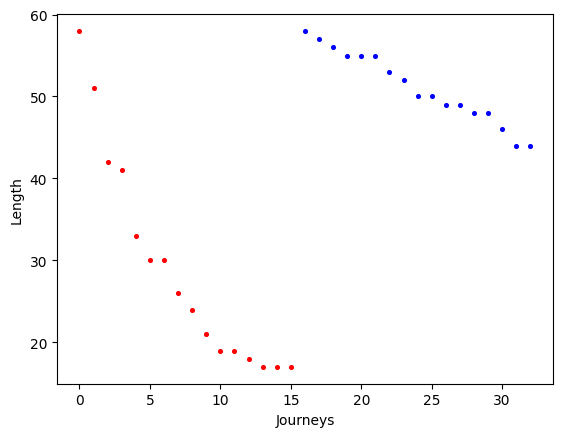

Includes #unsuccesfull: 16 and #succesfull 17
Histograms


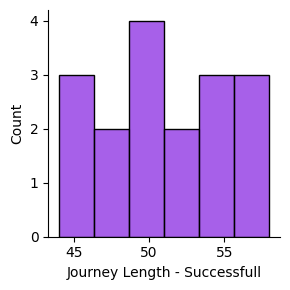

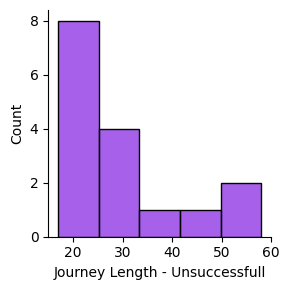

1970-01-27 15:22:16 1970-03-17 16:00:20
49 days 00:38:04 4235884.0


In [5]:
filtered_df_single = get_filtered_df("data.csv")
s1 = set(filtered_df_single["concept:name"])

started = filtered_df_single[filtered_df_single["concept:name"]=="registered"]
times = started["time:timestamp"]
print(min(times), max(times)) # two years
print(max(times)-min(times), (max(times)-min(times)).total_seconds())
WINDOW_SIZE = (max(times)-min(times)).total_seconds()

Found types {'activate', 'latency', 'score', 'resultsShared', 'subject', 'state', 'feedback', 'task', 'vpcInstance'}


/tmp/ipykernel_161061/209631736.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_161061/209631736.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


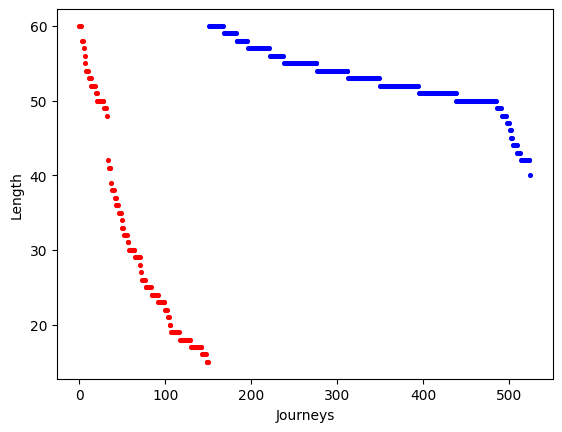

Includes #unsuccesfull: 151 and #succesfull 375
Histograms


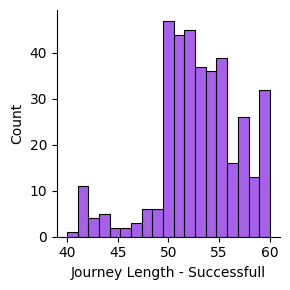

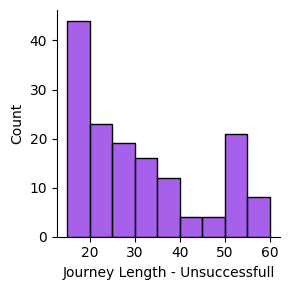

In [6]:
filtered_df = get_filtered_df("data_extended.csv")
s2 = set(filtered_df["concept:name"])

## Investigate starting time-stamp
We plot the companies, duration of all single journeys.
Additionally, we generate a histogram over the number of users starting at a certain time. 

       Company ID Category  case:DeveloperID      time:timestamp     Type  \
25807           9      B2B               571 1970-03-25 23:51:59    state   
25808           9      B2B               571 1970-03-26 22:32:28    state   
25809           9      B2B               571 1970-03-26 22:32:28  subject   
25810           9      B2B               571 1970-03-26 22:32:29    state   
25811           9      B2B               571 1970-03-26 22:32:29    state   

                  concept:name  Unnamed: 6  
25807               registered         NaN  
25808                activated         NaN  
25809      Logged in: Web page         NaN  
25810        vpcAssignInstance         NaN  
25811  vpcCreateUserOnInstance         NaN  
number companies 18


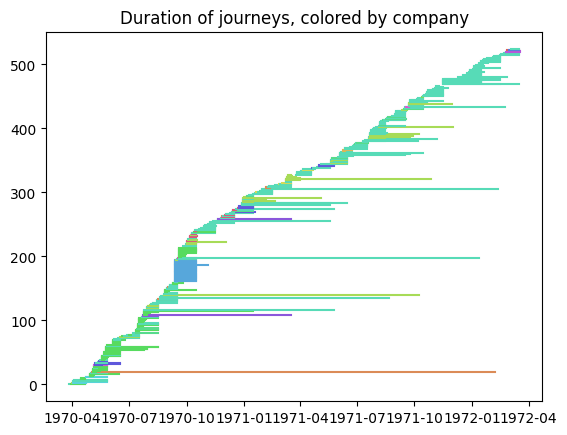

1970-03-25 23:51:59 1972-03-09 21:53:49


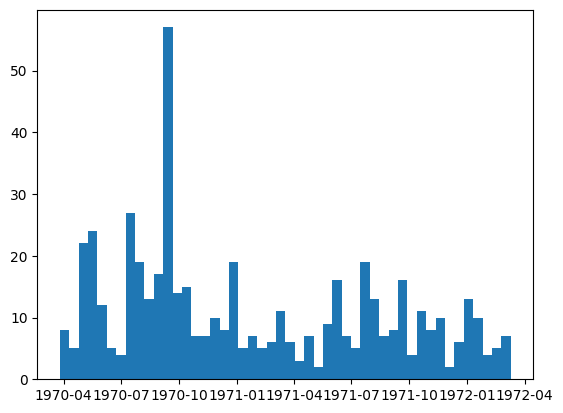

In [7]:
print(filtered_df.head())
times = {}
companies = {}
developers = set(filtered_df['case:DeveloperID'])

for d in developers:
    reduced = filtered_df[filtered_df['case:DeveloperID']==d]
    assert(len(set(reduced["Company ID"])) == 1)
    companies[d] = list(set(reduced["Company ID"]))[0]
    times[d] = (min(reduced["time:timestamp"]), max(reduced["time:timestamp"]))

number_companies = len(set(companies.values()))
company_iterator = {c : i for c,i in zip(set(companies.values()), range(number_companies))}
print("number companies", number_companies)

sorted_times = sorted(times.items(), key=lambda item: item[1])

count = 0
for t in sorted_times:
    company_it = company_iterator[companies[t[0]]]
    plt.plot([t[1][0],t[1][1]], [count, count], c=sns.color_palette("hls", number_companies)[company_it])
    count += 1
plt.title("Duration of journeys, colored by company")
plt.show()

started = filtered_df[filtered_df["concept:name"]=="registered"]
starting_times = started["time:timestamp"]
end_times = filtered_df.groupby(['case:DeveloperID']).max()["time:timestamp"]
print(min(starting_times), max(starting_times)) # two years
plt.hist(starting_times, 48)
plt.show()

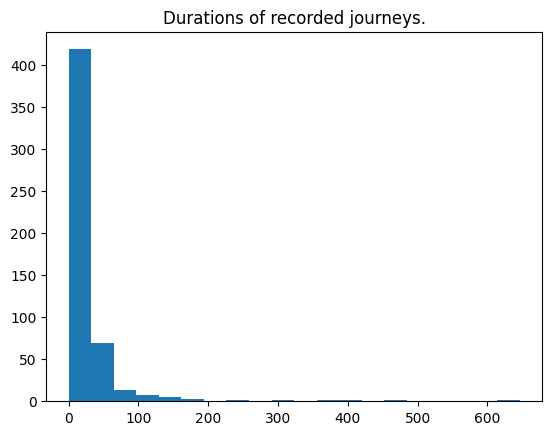

235


In [8]:
time_diffs = []
for t in times.values():
    time_diffs.append((t[1]-t[0]).days)

plt.hist(time_diffs, 20)
plt.title("Durations of recorded journeys.")
plt.show()

print(len([t for t in time_diffs if t > 21]))

# Build log
The dataset is flattened to a log structure

In [9]:
success_states = ['finished']
# A log consists of traces, where each trace contains all elements from one developer 
def build_log(df, return_start_times = False, return_execution_times = False):
    log = []
    start_times = [] # maps from developer to timestamp
    execution_times = []
    running_df = df.copy()
    print(running_df['time:timestamp'].dtype)
    #running_df['time:timestamp'] = running_df['time:timestamp'].to_datetime()
    running_df = running_df.sort_values(by=['time:timestamp'], kind = "stable")
    print(running_df.head(20))
    developers_id = set(running_df['case:DeveloperID'].values)
    for dev_id in developers_id:
        current_trace = running_df[running_df['case:DeveloperID'] == dev_id]['concept:name'].values
        current_times = running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'].values

        trace_start = min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])
        trace_end = max(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])

        if ((trace_end-trace_start).days > MAX_DURATION_JOURNEY):
            print("omitted developer", dev_id, "due to length")
            continue
        
        # add unique start node "start"
        current_trace = np.insert(current_trace,0,"start")
        current_times = np.insert(current_times,0,current_times[0])
        # attach final node finPos / finNeg
        if(any(s in current_trace for s in success_states)):
            current_trace = np.append(current_trace,"finPos")
            current_times = np.append(current_times,current_times[-1])
        else:
            current_trace = np.append(current_trace,"finNeg")
            current_times = np.append(current_times,current_times[-1])
        log.append(current_trace)
        start_times.append(min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp']))
        execution_times.append(current_times)
        assert(len(log[-1]) == len(execution_times[-1]))
    assert(len(log) == len(execution_times))

    # alter "logged in: Web page" to determine phase of journey:
    # Phase (1) sign up, (2) solve all programming tasks, and  (3) review and share the skill report with the customer.
    for t in log:
        indices = [i for i, x in enumerate(t) if x == "Logged in: Web page"]
        for i in indices:
            t[i] = "Logged in: Web page - Sign up"
            result = np.where(t == "Task event:")
            if "Task event:" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Task"
            result = np.where(t == "waitingForResultApproval")
            if "waitingForResultApproval" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Approval"
                
    # add task number
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_task:
            count_indices = [j for j in indices_feedback if j < i] # uses feedback to increase task counter after giving feedback
            t[i] += " "+str(len(count_indices))
    # add feedback number        
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_feedback:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """
    # add number to log in:
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_loggin = [i for i, x in enumerate(t) if x == "Task event: loggedIn"]
        for i in indices_loggin:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """

    if return_start_times:
        if return_execution_times:
            return log, start_times, execution_times
        else:
            return log, start_times
    else:
        if return_execution_times:
            return log, execution_times
        else:
            return log

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

In [10]:
def filter_doubles(log, execution_times = []):
    filtered_log = []
    filtered_execution_times = []
    for index in range(len(log)):
        # remove sequential same elements
        trace = log[index]
        current_trace = [trace[0]]
        if execution_times:
            current_times = [execution_times[index][0]]
        for pos in range(1,len(trace)):
            if trace[pos]==trace[pos-1]:
                continue
            current_trace.append(trace[pos])
            if execution_times:
                current_times.append(execution_times[index][pos])

        filtered_log.append(current_trace)
        if execution_times:
            filtered_execution_times.append(current_times)
    if execution_times == []:
        return filtered_log
    return filtered_log, filtered_execution_times

In [11]:
def ignore_loggin(log, execution_times = []):
    filtered_log = []
    filtered_execution_times = []
    for index in range(len(log)):
        # remove sequential same elements
        trace = log[index]
        current_trace = [trace[0]]
        if execution_times:
            current_times = [execution_times[index][0]]
        for pos in range(1,len(trace)):
            if "Task event: loggedIn" in trace[pos] or "Logged in: Web page" in trace[pos]:
                continue
            current_trace.append(trace[pos])
            if execution_times:
                current_times.append(execution_times[index][pos])

        filtered_log.append(current_trace)
        if execution_times:
            filtered_execution_times.append(current_times)
    if execution_times == []:
        return filtered_log
    return filtered_log, filtered_execution_times

In [12]:
log, start_times, execution_times = build_log(filtered_df, return_start_times=True, return_execution_times=True)
log, execution_times = ignore_loggin(log, execution_times)
log, execution_times = filter_doubles(log, execution_times)

datetime64[ns]
       Company ID Category  case:DeveloperID      time:timestamp     Type  \
25807           9      B2B               571 1970-03-25 23:51:59    state   
25808           9      B2B               571 1970-03-26 22:32:28    state   
25809           9      B2B               571 1970-03-26 22:32:28  subject   
25810           9      B2B               571 1970-03-26 22:32:29    state   
25811           9      B2B               571 1970-03-26 22:32:29    state   
25812           9      B2B               571 1970-03-26 22:32:41    state   
25813           9      B2B               571 1970-03-26 22:42:53    state   
25814           9      B2B               571 1970-03-26 22:42:54     task   
25815           9      B2B               571 1970-03-26 22:42:56     task   
25816           9      B2B               571 1970-03-26 22:44:32     task   
25817           9      B2B               571 1970-03-28 23:04:52  subject   
11844           6      B2C               660 1970-03-30 05:59

omitted developer 93 due to length
omitted developer 233 due to length
omitted developer 270 due to length
omitted developer 658 due to length
omitted developer 720 due to length
omitted developer 1041 due to length
omitted developer 1103 due to length
omitted developer 1249 due to length


In [13]:
print("Variants before removing trivial elements")
print(len(Counter(str(e) for e in log).keys()))

Variants before removing trivial elements
50


In [14]:
log_single, single_start_times, single_execution_times = build_log(filtered_df_single, return_start_times=True, return_execution_times=True)
log_single, single_execution_times = ignore_loggin(log_single, single_execution_times)
log_single, single_execution_times = filter_doubles(log_single, single_execution_times)

datetime64[ns]
      Company ID Category  case:DeveloperID      time:timestamp     Type  \
1963           9      B2B                70 1970-01-27 15:22:16    state   
1964           9      B2B                70 1970-01-28 14:02:45    state   
1965           9      B2B                70 1970-01-28 14:02:45  subject   
1966           9      B2B                70 1970-01-28 14:02:46    state   
1967           9      B2B                70 1970-01-28 14:02:46    state   
1968           9      B2B                70 1970-01-28 14:02:58    state   
1969           9      B2B                70 1970-01-28 14:13:10    state   
1970           9      B2B                70 1970-01-28 14:13:11     task   
1971           9      B2B                70 1970-01-28 14:13:13     task   
1972           9      B2B                70 1970-01-28 14:14:49     task   
1973           9      B2B                70 1970-01-30 14:35:09  subject   
1421           8      B2C                97 1970-01-31 21:30:14    state 

Variants before removing trivial elements
50


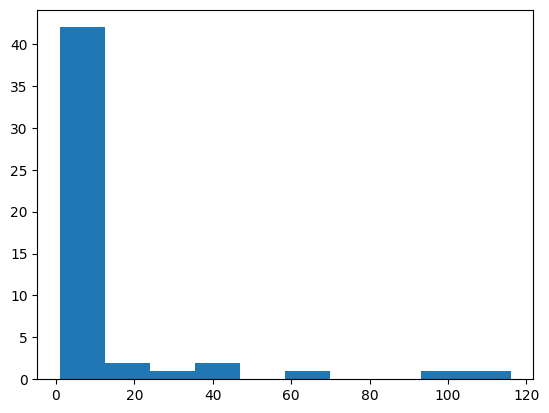

In [15]:
# variants in log
print("Variants before removing trivial elements")
variants_counter = Counter(str(e) for e in log)
plt.hist(variants_counter.values(), 10)
print(len(Counter(str(e) for e in log).keys()))

# Create DFG

In [16]:
# Builds the directly follows graph according to the log
# Removes all edges which are traversed less than "threshold" times
def build_dfg(log, threshold):
    states = list(set([item for sublist in log for item in sublist])) # flatten list

    edges = []
    edge_counter = {}
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
    
    g = nx.DiGraph()
    g.add_nodes_from(states)
    max_val = max(edge_counter.values())
    for e in edges:
        g.add_edge(e[0], e[1], edge_weight = edge_counter[e]/max_val) # adds "thickness" element

    # remove all simple loops & rarely traversed edges
    to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            to_remove.append(e)

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
            
    
    # remove isolated nodes
    g.remove_nodes_from(list(nx.isolates(g)))
    
    return g

def draw_dfg(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"
    for e in g.edges:
        e = A.get_edge(e[0], e[1])
        if 'controllable' in g.edges[e]:
            if not g.edges[e]['controllable']:
                e.attr["style"] = "dotted"
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
    print("plotted", name)

In [17]:
g = build_dfg(log_single, 0)
draw_dfg(g, "graph.ps")

plotted graph.ps


# Burnd-Down Chart of Developers

In [18]:
# Draw the burn down chart of developers leaving the journey per touchpoint, Figure 6
def draw_burn_down(g,s, t, log):
    g_copy = copy.deepcopy(g)
    edge_counter = {}
    node_counter = {}
    
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edge_counter:
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
            
    for trace in log:
        for pos in set(trace):
            if pos in node_counter:
                node_counter[pos] = node_counter[pos]+1
            else:
                node_counter[pos] = 1
            continue

    for e in edge_counter:
        if e[1] == "finNeg":
            print(e, edge_counter[e])
    
    x = [100,81, 72, 64, 52]
    y = ["start", "T10", "T12", "T14", "T25"]
    x2 = [0,18,9,9,12]
    y2 = ["start", "T10", "T12", "T14", "T25"]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(y,x, 'o-')
    ax.bar(y2, x2, color="r")
    plt.ylabel("Developers (in %)", fontsize=18)
    plt.xlabel("Events", fontsize=18)
    plt.show()

('Task event: 1', 'finNeg') 6
('Task event: 2', 'finNeg') 3
('waitingForActivityReport', 'finNeg') 4
('Task event: 3', 'finNeg') 3


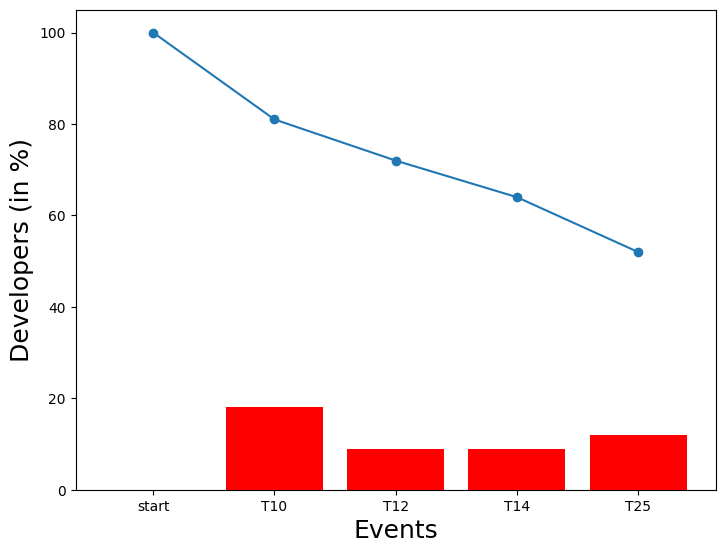

In [19]:
draw_burn_down(g, "start", "finNeg", log_single)

# DFG to Customer Journey Game

In [20]:
# load actors from given file
# The file maps events to actors in xml format
# Every unspecified event is controllable
with open('activities.xml') as f:
    data = f.read()
actors = json.loads(data)

In [21]:
# stores actors in graph
def extend_graph_with_actors(g, actors, transition_system=False):
    if not transition_system:
        for node in g.nodes:
            if node not in actors:
                g.nodes[node]['controllable'] = True
            else:
                g.nodes[node]['controllable'] = actors[node] == "company"
    else:
        for e in g.edges:
            controllable_set = False
            for key in actors:
                if key in g.edges[e]['action']:
                    controllable_set = True
                    g.edges[e]['controllable'] = actors[key] == 'company'
            if not controllable_set:
                g.edges[e]['controllable'] = True

In [22]:
extend_graph_with_actors(g, actors)

In [23]:
# Helper functions to compute weights for edges

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

def weight(trace):
    return 1 if any("finished" in pos for pos in trace) else -1

def majority(s,t,log):
    maj = 0
    for trace in log:
        if isInTrace(s,t,trace):
            maj += weight(trace)
    return 1 if maj == 0 else int(maj/abs(maj))

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping = []):
    distr = {1.0: 0 , -1.0 : 0}
    if edge_mapping == []: # old function
        for trace in log:
            if isInTrace(s,t,trace):
                w = weight(trace)
                distr[w] += 1
    else:# use abstraction
        assert((s,t) in edge_mapping)
        for trace_index in set(edge_mapping[(s,t)]):
            w = weight(log[trace_index])
            distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, log, edge_mapping = []):
    weights = [1 if "finished" in i else -1 for i in log]
    edge_cost = {}
    for s in g.nodes:
        for t in g[s]:
            p1, p2 = distribution(s,t,log, edge_mapping)
            if p1 +  p2 == 0:
                assert(False)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            #w = majority(s,t,log)
            w = 1 if p1 >= p2 else -1
            scaling = 10
            edge_cost[(s,t)] = (((1-entropy(wp1,wp2)) * w) -0.1 )*20
    print("Edge cost was computed")
    return edge_cost

In [24]:
edge_cost = compute_edge_cost(g, log_single)

Edge cost was computed


In [25]:
# annotates graph with cost-labels
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

# Colors graph labels green/red depending of the weight is positive or negative
def color_graph(g):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > 0:
            g[e[0]][e[1]]['color'] ="darkgreen"
        if g[e[0]][e[1]]['label'] < 0:
            g[e[0]][e[1]]['color'] ="red"
    
    return g

# Plots clustered DFG, Figure 5
def draw_dfg_clustered(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    g.graph['graph']={'rankdir':'LR'}

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = 70
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"

    for n in A.nodes():
        n.attr['fontsize'] = 80
    #onboarding = ["T"+str(i) for i in range(0,6)]
    #A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 60, fontcolor = "orange")
    task = ["T"+str(i) for i in range(6,21)]
    #task = [k for k in naming if naming[k] in task ]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 60, fontcolor = "blue")
    evaluation = ["T"+str(i) for i in range(21,27)]
    #evaluation = [k for k in naming if naming[k] in evaluation ]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 60, fontcolor = "purple")

    reversed_naming = {naming[i] : i for i in naming}
    for n in A.nodes():
        if n not in reversed_naming:
            continue
        n.attr['label'] = n#reversed_naming[n]
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
        
# Introduced naming for readable function
naming = {
    "registered" : "T0",
    "activated": "T1",
    "Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T4",
    "readyToStart" : "T5",
    "Task event: loggedIn" : "T6",
    "started" : "T7",
    "Task event: 0": "T8",
    "Give feedback 0" : "T9",
    "Task event: 1": "T10",
    "Give feedback 1" : "T11",
    "Task event: 2": "T12",
    "Give feedback 2" : "T13",
    "Task event: 3": "T14",
    "Give feedback 3" : "T15",
    "Task event: 4": "T16",
    "Give feedback 4" : "T17",
    "Task event: 5": "T18",
    "waitingForManualScores" : "T19",
    "Logged in: Web page - Task" : "T20",
    "waitingForScores" : "T21",
    "waitingForResultApproval" : "T22",
    "waitingForSubjectAcceptance" : "T23",
    "subjectAcceptanceReceived" : "T24",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Logged in: Web page - Approval" : "T26"
}

In [26]:
for n in g.nodes:
    print(n)

g = annotate_graph(g, edge_cost)
g_outgoing = color_graph(g)

g_outgoing.remove_node("Results shared")
g_outgoing.remove_node("start")
g_outgoing.remove_node("registered")
g_outgoing.remove_node("activated")
g_outgoing.remove_node("vpcCreateUserOnInstance")
g_outgoing.remove_node("vpcAssignInstance")
g_outgoing.remove_node("readyToStart")
g_outgoing.remove_node("started")
g_outgoing.remove_node("waitingForManualScores")

g_outgoing = nx.relabel_nodes(g_outgoing, naming)

g_outgoing.remove_edges_from(nx.selfloop_edges(g_outgoing)) # T24 introduces self loop
draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

readyToStart
Give feedback 2
registered
Give feedback 1
Results shared
waitingForScores
Task event: 3
waitingForActivityReport
vpcAssignInstance
vpcCreateUserOnInstance
start
Results automatically shared
Give feedback 4
waitingForManualScores
subjectAcceptanceReceived
waitingForSubjectAcceptance
activated
Task event: 4
started
finPos
Task event: 0
waitingForResultApproval
Task event: 5
finished
finNeg
Give feedback 0
Give feedback 3
Task event: 2
Task event: 1


# Mapping to UPPAAL Model

In [27]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True


# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split("vv")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "vv" not in t:
                            t += "vv1"
                        else:
                            t = t.split("vv")[0]+"vv"+str(int(t.split("vv")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]): # transition systems store controllability in edges
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('controllable' in G.nodes[t_original]): # dfg stores in nodes
                    G_gen.nodes[t]['controllable'] = G.nodes[t_original]['controllable']

    print("Graph was unrolled")
    return G_gen

In [28]:
g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
A = to_agraph(g_unroll)
A.layout('dot')
if SAVE_ELEMENTS:
    A.draw('unrolled.ps')

Graph was unrolled


In [29]:
# Method to produce unrolled graph
def to_uppaal(g):
    f = open("unrolled_graph.xml", "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot', args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'int finalGasMax = 0;')
    f.write('\n'+'int finalGasMin = 10000;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    for e in g.edges:
        final = True if "finPos" in e[1] or "finNeg" in e[1] else False
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g.nodes[e[1]]['controllable'], final = final)
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("All written to", f.name)

def print_location(f, location_id, x, y, name):
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y))+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if "finPos" not in name and "finNeg" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, weight, controllable, final = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if final:
        f.write('finalGasMax = gas +'+str(int(round(weight))))
        f.write(',\n'+'finalGasMin = gas +'+str(int(round(weight))))
        f.write(',\n'+ 'gas = gas + '+str(int(round(weight))))
    else:
        f.write('gas = gas + '+str(int(round(weight))))
    
    f.write(',\n'+ 'steps += 1')
    f.write(',\n'+ 'x = 0')
    
    f.write('</label>')
    
    f.write('</transition>')


In [30]:
if SAVE_ELEMENTS:
    to_uppaal(g_unroll)

All written to unrolled_graph.xml


##  UPPAAL
This generated model can then by model checked with UPPAAL.

# Generate Simulation Plot
Generates comparison plot between GoPos and GoPosFast, Figure 7

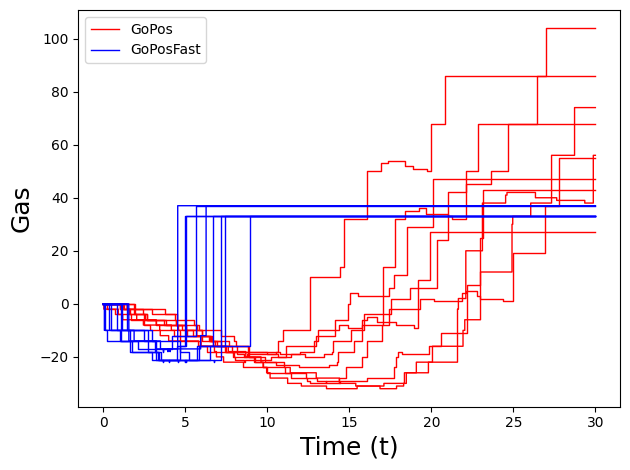

In [31]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

x,y = read_csv("gopos.csv")
x_fast, y_fast = read_csv("goposfast.csv")
plt.rcParams["figure.autolayout"] = True
for i in range(len(x)):
    if i == len(x)-1:
        plt.plot(x[i],y[i], c = "r", linewidth = 1, label = "GoPos")
    else:
        plt.plot(x[i],y[i], c = "r", linewidth = 1)
for i in range(len(x_fast)):
    if i == len(x_fast)-1:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1, label = "GoPosFast")
    else:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1)
plt.legend()
plt.savefig("simulation.png")
plt.xlabel("Time (t)",  fontsize=18)
plt.ylabel("Gas",  fontsize=18)
plt.show()

## Write transition system to UPPAAL

In [32]:
# Concats the trace to a multiset-history
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos not in multiset:
            multiset[pos] = 1
        else:
            multiset[pos] += 1
    return json.dumps(multiset, sort_keys=True).encode().decode("utf-8") # use json encodings for multisets

# Computes the sequence-history of the given trace
def sequence(trace): 
    hist = str(trace[0])
    for pos in trace[1:]:
        hist += " - " + str(pos) # construct history
    return hist

# Function to compute a transition system, given a pre-processed log
def transition_system(log, history, abstraction):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = abstraction(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                if trace_index not in edge_mapping[e] or True:
                    # if transition observed twice in one run, dont count twice in computation
                    edge_counter[e] = edge_counter[e]+1
                    edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = [] # to remove selve-loops
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        # set properties
        g[e[0]][e[1]]['action'] = action[e]

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    return g, edge_mapping

In [33]:
#transition system needs different write-to-xml methods

# construction of uppaal model (write model into upaal file)
def to_uppaal_transition(g, name, layout = "sfdp", debug = False):
    f = open(name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool reached_positive = false;')
    f.write('\n'+'bool reached_negative = false;')
    f.write('\n'+'bool phase0 = true;')
    f.write('\n'+'bool phase1 = false;')
    f.write('\n'+'bool phase2 = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location_transition(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for e in g.edges:
        assert("label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]])
        print_edge_transition(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)

    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    if debug:
        print("all written to", f.name)

def print_location_transition(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "finPos" not in name and "finNeg" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge_transition(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):  

    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
        
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "finPos" in str(e[1]):
        f.write(',\n'+ 'reached_positive = true')
        f.write(',\n'+ 'final_gas = gas +'+str(int(round(w))))
    elif "finNeg" in str(e[1]):
        f.write(',\n'+ 'reached_negative = true')
        f.write(',\n'+ 'final_gas = gas + '+str(int(round(w))))
        
    if "started - Task event: 0" in e[1]:
        f.write(',\n'+ 'phase0 = false')
        f.write(',\n'+ 'phase1 = true')
    if "waitingForResultApproval" in e[1]:
        f.write(',\n'+ 'phase1 = false')
        f.write(',\n'+ 'phase2 = true')

    f.write(',\n'+'gas = gas + '+str(int(round(w))))
    f.write('</label>')
    
    f.write('</transition>')

# Analysing Time Series

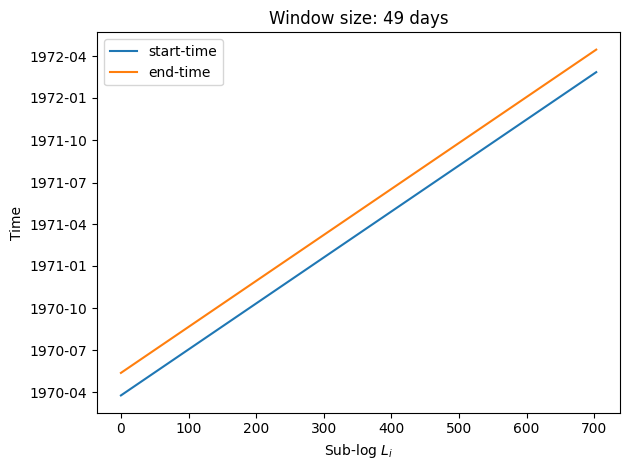

In [34]:
# sort log with start_times

# most prominent companies
reduced_sorted_times = [t for t in sorted_times if (t[1][1]- t[1][0]).days < MAX_DURATION_JOURNEY]
company_list = []
for t in reduced_sorted_times:
    company_index = company_iterator[companies[t[0]]]
    company_list.append(company_index)

# generates sliding window log
def sliding_window_logs(log, start_times, execution_times, window_size_days = 49, min_size = 30, companies = [], draw_plot = False):
    # assert that log, start_times and execution_times have right format
    assert(len(log) == len(start_times))
    for i in range(len(log)):
        assert(len(log[i])==len(execution_times[i]))

    merged = [(log, start_time, execution_time) for log, start_time, execution_time in zip (log, start_times, execution_times)]
    start_times_sorted = sorted(merged, key=lambda item: item[1])
    sorted_log = [s[0] for s in start_times_sorted]
    sorted_times = [s[1] for s in start_times_sorted]
    sorted_execution_times = [s[2] for s in start_times_sorted]

    assert(len(sorted_execution_times) == len(sorted_log))
    assert(sorted(start_times) == sorted_times)
    assert(len(sorted_times)==len(sorted_execution_times))
    for i in range(len(sorted_times)):
        assert(sorted_times[i]==sorted_execution_times[i][0])
        assert(len(sorted_log[i])==len(sorted_execution_times[i]))
    
    sliced_logs = []
    sliced_companies = []
    sliced_execution_times = []
    sliced_start = []
    sliced_end = []
    
    latest_time = max(sorted_times)

    for current_start in (min(sorted_times) + timedelta(days = n) for n in range((max(sorted_times)-min(sorted_times)).days+2)): # iterate over all days
        window_start = datetime.datetime(current_start.year, current_start.month, current_start.day, 0, 0, 0)
        window_end = datetime.datetime(current_start.year, current_start.month, current_start.day, 0, 0, 0)+timedelta(days = window_size_days)

        # assure minimal window size
        if (latest_time - current_start).days <= min_size:
            continue
        current_log = []
        current_companies = []
        current_execution_times = []
        index = -1
        # check on all traces and build sliced lists
        for trace, start_time, execution_time in zip(sorted_log, sorted_times, sorted_execution_times):
            assert(len(trace) == len(execution_time))
            index += 1
            if start_time >= window_start and start_time < window_end:
                current_log.append(trace)
                current_execution_times.append(execution_time)
                if companies != []:
                    current_companies.append(companies[index])

        sliced_logs.append(current_log)
        sliced_companies.append(current_companies)
        sliced_execution_times.append(current_execution_times)
        sliced_start.append(window_start)
        sliced_end.append(window_end)
    
    # visualize start-times of 
    if draw_plot:
        plt.plot(range(len(sliced_start)), sliced_start, label = "start-time")
        plt.plot(range(len(sliced_end)), sliced_end, label = "end-time")
        plt.title("Window size: "+str(window_size_days)+ " days")
        plt.xlabel(r'Sub-log $L_i$')
        plt.ylabel("Time")
        plt.legend()
        if SAVE_ELEMENTS:
            plt.savefig("windows.png")
        plt.show()
    if companies == []:
        return sliced_logs, sliced_execution_times
    else:
        return sliced_logs, sliced_companies, sliced_execution_times

sliced_logs, sliced_companies, sliced_execution_times = sliding_window_logs(log, start_times, execution_times, min_size = 10, draw_plot = True, window_size_days=49, companies=company_list)

Number of sliced logs 704


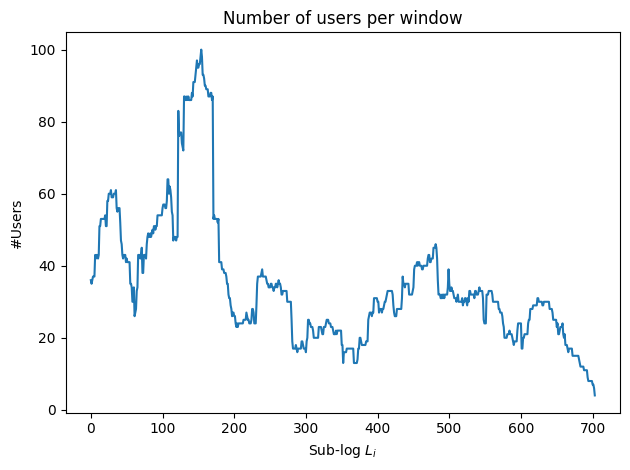

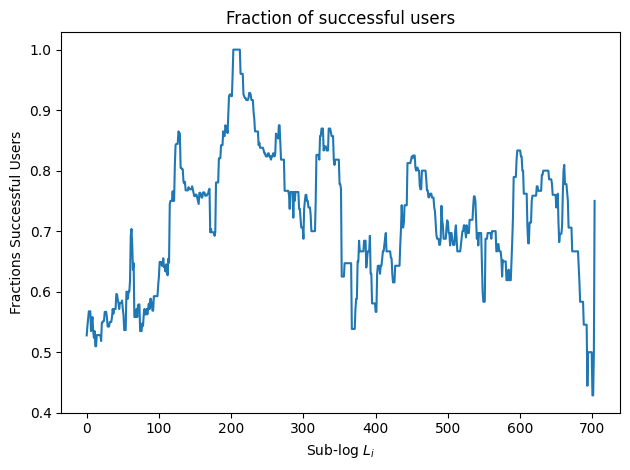

In [35]:
# plot development of users and fraction of successful users

print("Number of sliced logs", len(sliced_logs))

plt.plot(range(len(sliced_logs)), [len(l) for l in sliced_logs])
plt.title("Number of users per window")
plt.xlabel(r'Sub-log $L_i$')
plt.ylabel("#Users")
if SAVE_ELEMENTS:
    plt.savefig("#users.png")
plt.show()

fractions = []
for l in sliced_logs:
    pos = [t for t in l if "finPos" in t]
    neg = [t for t in l if "finNeg" in t]
    assert(len(l) >0)
    fractions.append(len(pos)/len(l))
    assert(len(pos)+len(neg) == len(l))
plt.plot(range(len(fractions)), fractions)
plt.title("Fraction of successful users")
plt.xlabel(r'Sub-log $L_i$')
plt.ylabel("Fractions Successful Users")
if SAVE_ELEMENTS:
    plt.savefig("fractions.png")
plt.show()

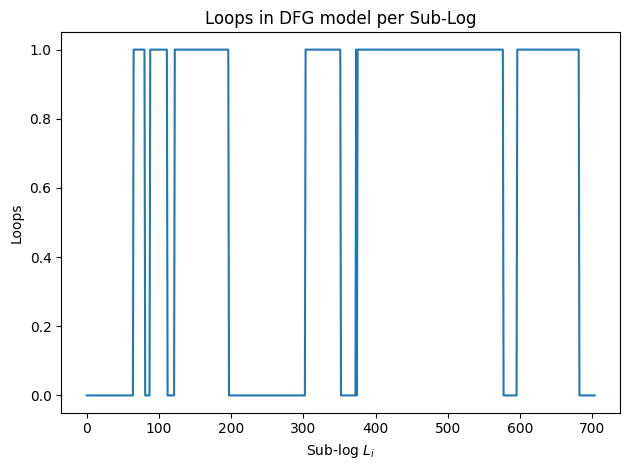

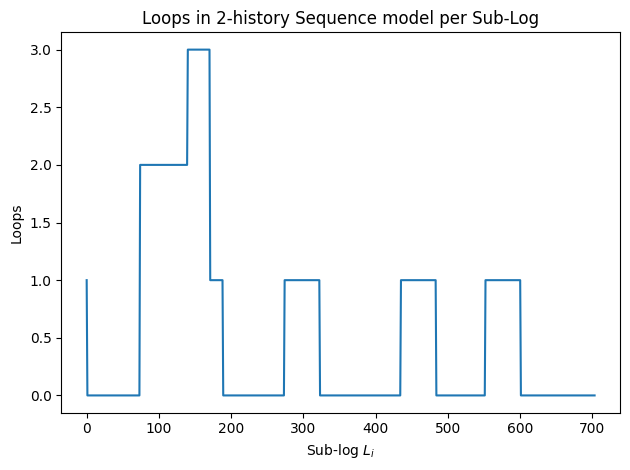

In [36]:
# Compare dfg construction with sequence construction
def analyse_models(sliced_logs):
    loops = []
    for l in sliced_logs:
        help_g = build_dfg(l, 3)
        loops.append(len(list(nx.simple_cycles(help_g))))
    plt.title("Loops in DFG model per Sub-Log")
    plt.xlabel(r'Sub-log $L_i$')
    plt.ylabel("Loops")
    plt.plot(range(len(loops)), loops)
    plt.show()

    loops = []
    for l in sliced_logs:
        help_g, edge_mapping = transition_system(l, 2, sequence)        
        loops.append(len(list(nx.simple_cycles(help_g))))
    plt.title("Loops in 2-history Sequence model per Sub-Log")
    plt.xlabel(r'Sub-log $L_i$')
    plt.ylabel("Loops")
    plt.plot(range(len(loops)), loops)
    plt.show()

analyse_models(sliced_logs)

In [37]:
def plot_results(result_dict):
    colors = result_dict["colors"]
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))
    axs[0,0].hist(result_dict["loops"], 20)
    axs[0,0].set_title("Loop Histogram")

    axs[0,1].scatter(range(len(result_dict["loops"])), result_dict["loops"], s = 2)
    axs[0,1].set_title("Loops")

    axs[1,0].scatter(range(len(result_dict["distances"])), result_dict["distances"], s = 2)
    axs[1,0].set_title("Distances")

    axs[1,1].scatter(range(len(result_dict["distances_previous"])), result_dict["distances_previous"], s = 2)
    axs[1,1].set_title("Pairwise - Distances")
    
    axs[2,0].plot(range(len(result_dict["fractions"])), result_dict["fractions"])
    axs[2,0].set_title("Fractions")

    axs[2,1].plot(range(len(result_dict["sliced_logs"])), [len(l) for l in result_dict["sliced_logs"]])
    axs[2,1].set_title("#Users")

    axs[3,0].scatter(range(len(result_dict["negative_edges"])), [len(e) for e in result_dict["negative_edges"]], s = 10)
    axs[3,0].set_title("Number negative edges")

    plt.show()

def plot_mc_results(mc_results, colors):
    lables = [r'$E(steps)$', "min Gas", "max finalGas"]
    for i in range(6):
        plt.plot(range(len(mc_results)), [r[i] for r in mc_results])
        if "min" in lables[i%3]:
            x = [ind for ind in range(len(mc_results)) if mc_results[ind][i] == 1]
        else:
            x = [ind for ind in range(len(mc_results)) if mc_results[ind][i] == -1]
        plt.scatter(x, np.array([r[i] for r in mc_results])[x], marker ="x", c = "red")
        plt.axvspan(0, 120, facecolor='green', alpha=0.2)
        plt.axvspan(270, 320, facecolor='red', alpha=0.2)
        plt.axvspan(390, 450, facecolor='red', alpha=0.2)
        plt.axvspan(550, 585, facecolor='red', alpha=0.2)
        plt.xlabel(r'Sub-log $L_i$', size = 20)
        plt.ylabel(lables[i%3], size = 20)
        if SAVE_ELEMENTS:
            plt.savefig("mc_"+str(i)+".png")
        plt.show()


In [38]:
g_old_history, h = transition_system(log_single, 2, sequence)

## Time Series Analysis

In [39]:
def time_analysis(sliced_logs, abstraction_length = 1, edge_threshold = 0, compute_distance = True, distance_time = 10, draw_intermediate = False):
    result_dict = {
        "loops" : [],
        "mc_results" : [],
        "distances" : [],
        "distances_previous" : [0],
        "colors" : [],
        "fractions" : [],
        "edge_thresholds" : [],
        "negative_edges" : [],
        "sliced_logs" : sliced_logs
    }

    omitted_counter = 0
    successfully_computed = 0

    for l in sliced_logs:
        # add default values if sub-log is empty (might occur when investigating companies)
        if len(l) == 0:
            result_dict["loops"].append(-1)
            result_dict["mc_results"].append([-10,-10,-10,-10,-10,-10])
            result_dict["distances"].append(-1)
            result_dict["distances_previous"].append(-1)
            result_dict["colors"].append("violet")
            result_dict["fractions"].append(-1)
            continue
        result_dict["fractions"].append(len([t for t in l if "finPos" in t])/len(l))
            

        if compute_distance:
            if len(result_dict["distances"]) > 0:
                h1, h2 = transition_system(l, abstraction_length, sequence)
                result_dict["distances_previous"].append(nx.graph_edit_distance(h1, help_g, timeout = distance_time))

        # build model
        help_g, edge_mapping = transition_system(l, abstraction_length, sequence)
        extend_graph_with_actors(help_g,actors, transition_system=True)
        edge_to_remove = []
        for e in help_g.edges:
            if len(edge_mapping[e]) <= edge_threshold:
                edge_to_remove.append(e)
        help_g.remove_edges_from(edge_to_remove)
        help_g.remove_nodes_from(list(nx.isolates(help_g)))

        loop_number = len(list(nx.simple_cycles(help_g)))

        if compute_distance:
            print("compute distance")
            result_dict["distances"].append(nx.graph_edit_distance(g_old_history, help_g, timeout = distance_time))

        result_dict["loops"].append(loop_number)
        result_dict["edge_thresholds"].append(edge_threshold)

        assert(not nx.is_empty(help_g))
        assert(nx.is_weakly_connected(help_g))
        if loop_number > 6:
            #assume that all models have sufficiently little loops
            assert(False)
        
        #compute cost for model
        help_edge_cost = compute_edge_cost(help_g, l, edge_mapping)
        help_g = annotate_graph(help_g, help_edge_cost)

        negative_edges = [e for e in help_edge_cost if help_edge_cost[e] < 0]
        result_dict["negative_edges"].append(negative_edges)
        
        if draw_intermediate:
            draw_dfg(help_g, "graph_loops.ps")
        
        assert("start" in help_g.nodes)

        target = [s for s in help_g.nodes if "finPos" in s or "finNeg" in s]
        help_g_unroll = unroll(help_g, "start", target, 1)
        
        if draw_intermediate:
            draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
        
        # write to uppaal
        to_uppaal_transition(help_g_unroll, "unrolled_graph_transition.xml", layout = "dot")
        # run queries
        out = subprocess.Popen([VERIFYTA_PATH, "unrolled_graph_transition.xml", "unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        # parse output
        results, err = out.communicate()
        results = results.decode("utf-8") 
        err = str(err.decode("utf-8"))
        if err != "":
            results = [-1,1,-1,-1,1,-1]
        else:
            results = results.split("\n")
            results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
            results = [r.replace("≈", "") for r in results]
            results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
            successfully_computed += 1
        assert(len(results) == 6)

        result_dict["mc_results"].append(results)
        
        result_dict["colors"].append("b" if results == [-1,1,-1,-1,1,-1] else "g")
        print("Progress", len(result_dict["loops"]), "/", len(sliced_logs))

    print("Successfully computed", successfully_computed)
    return result_dict

In [40]:
def compute_distances_pairwise(i):
    distance_time = 10
    if i == 0:
        return 0
    c1, c2 = transition_system(sliced_logs[i], 2, sequence)
    o1, o2 = transition_system(sliced_logs[i-1], 2, sequence)
    return nx.graph_edit_distance(c1, o1, timeout = distance_time)

def compute_distances(i):
    distance_time = 10
    c1, c2 = transition_system(sliced_logs[i], 2, sequence)
    return nx.graph_edit_distance(g_old_history, c1, timeout = distance_time)


In [ ]:
if COMPUTE_SEQUENCE:
    result_dict_sequence = time_analysis(sliced_logs, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
    if COMPUTE_SEQUENCE_DISTANCE:
        with Pool(N_PROCESSORS) as p:
            result_dict_sequence['distances_previous'] = p.map(compute_distances_pairwise, range(len(sliced_logs)))
            result_dict_sequence['distances'] = p.map(compute_distances, range(len(sliced_logs)))
    if SAVE_ELEMENTS:
        with open('result_dict_sequence.pkl', 'wb') as f:
            pickle.dump(result_dict_sequence, f)

In [42]:
if not COMPUTE_SEQUENCE:
    with open('result_dict_sequence.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    result_dict_sequence = loaded_dict

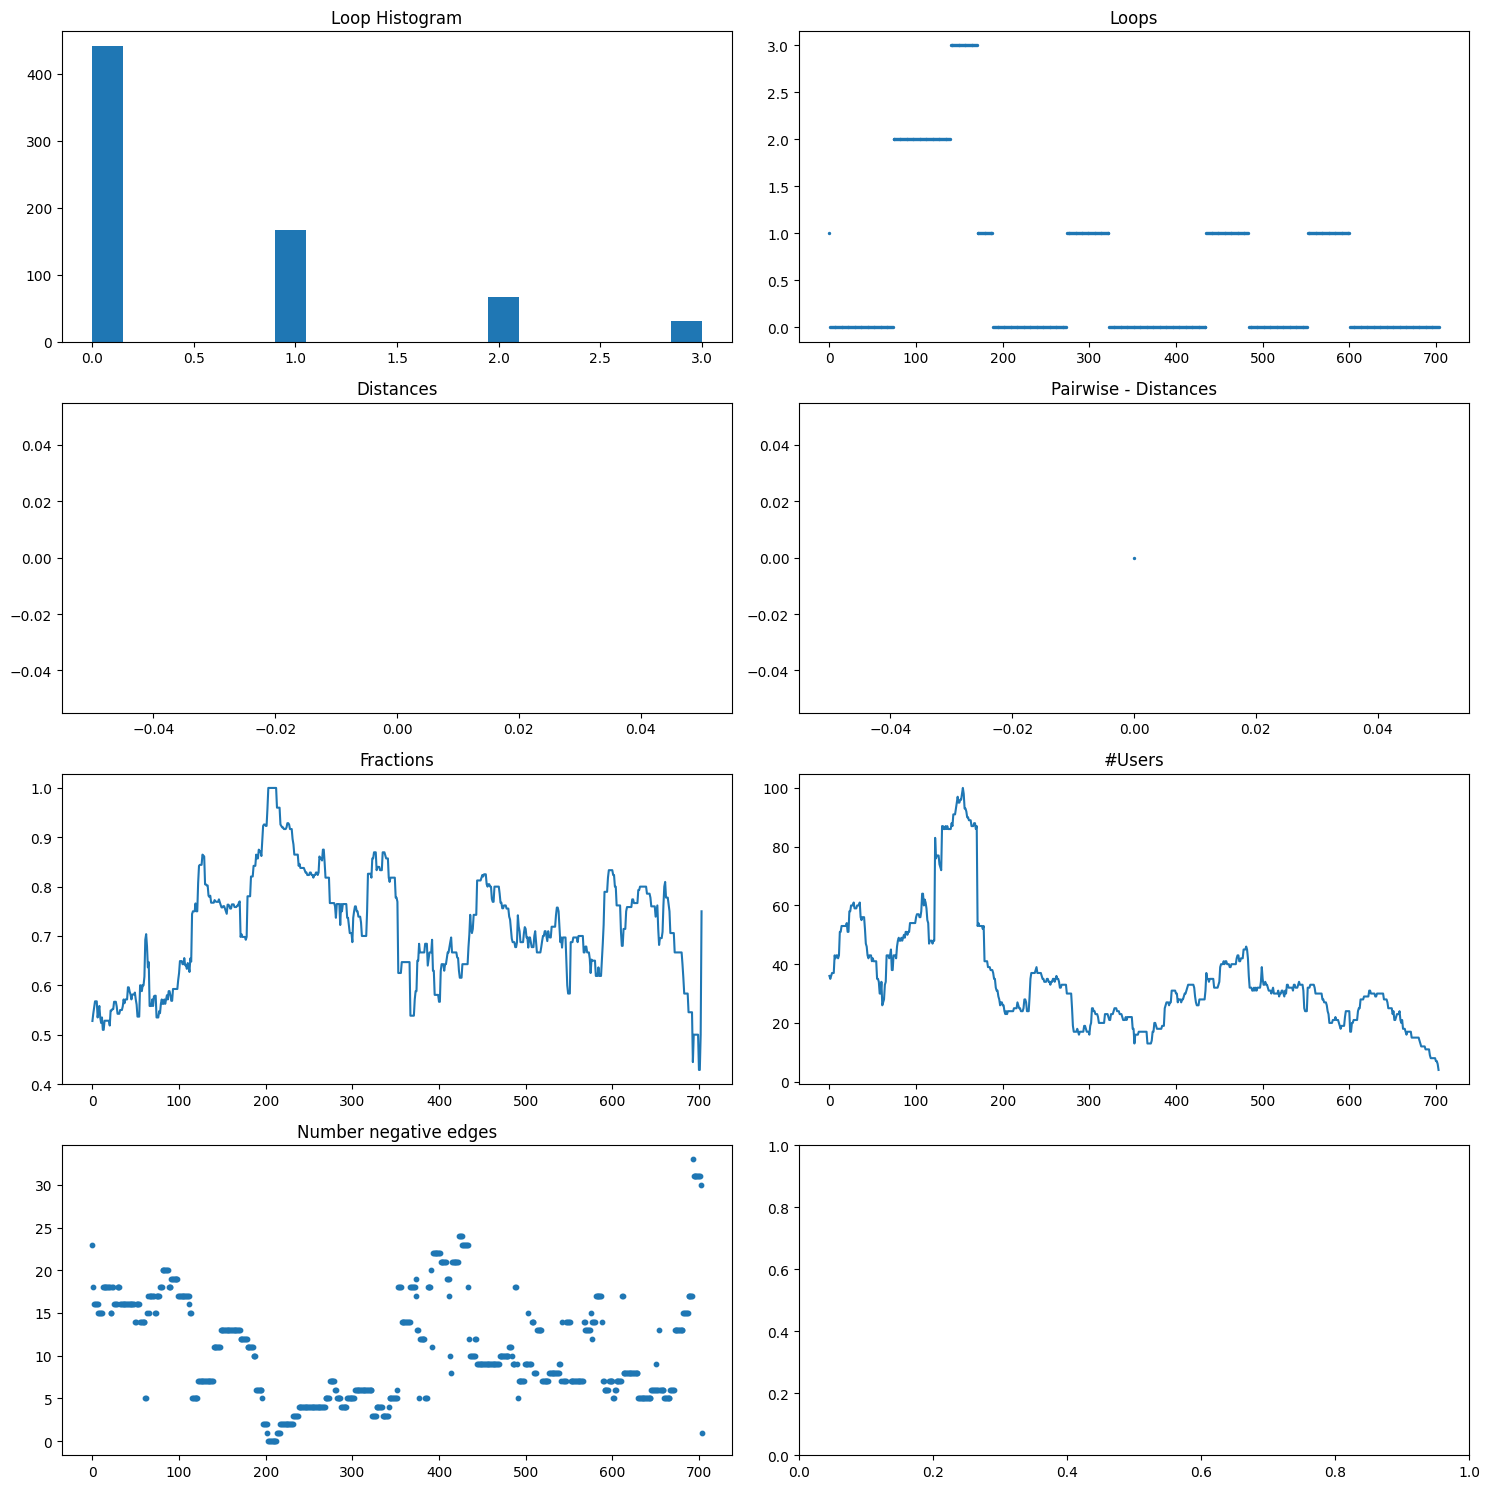

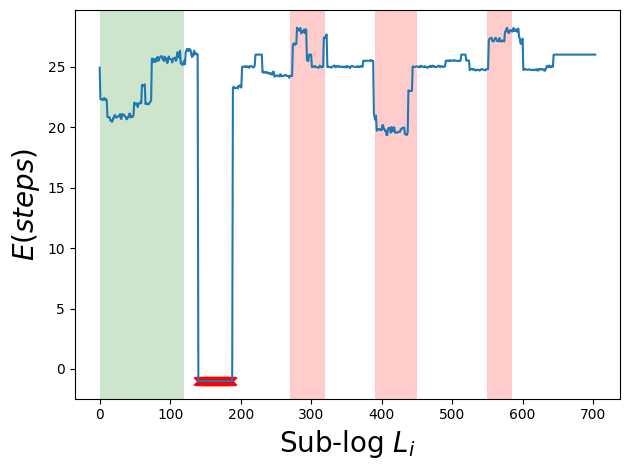

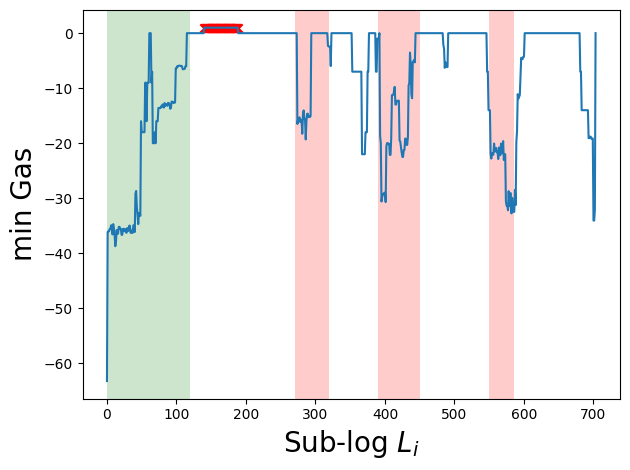

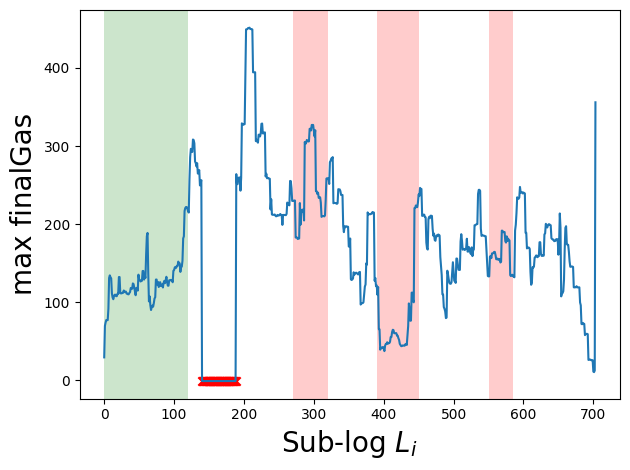

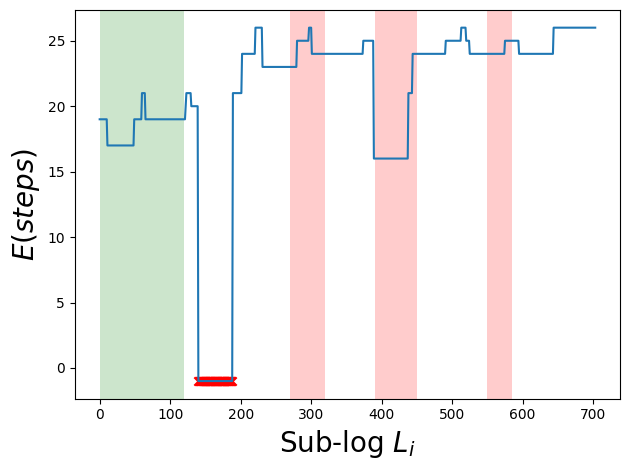

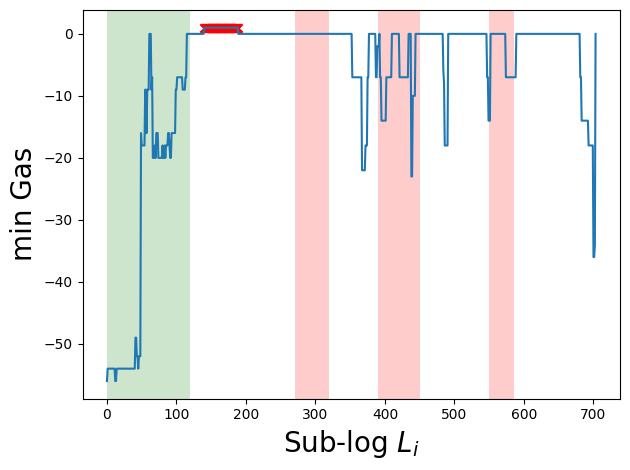

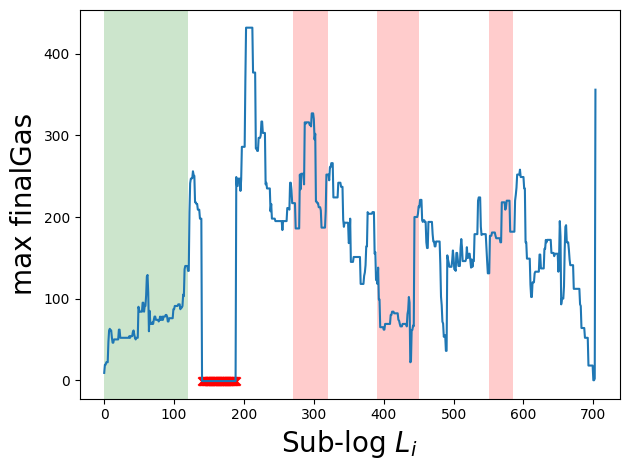

In [43]:
plot_results(result_dict_sequence)
plot_mc_results(result_dict_sequence["mc_results"], result_dict_sequence["colors"])

In [44]:
def detect_range(L):
    for i, j in itertools.groupby(enumerate(L), lambda x: x[1] - x[0]):
        j = list(j)
        start = j[0][1]
        length = len(j)

        if length == 1:
            yield start
        else:
            yield (start, start+length)

range min gas 225 [(0, 55), 57, (66, 99), (274, 294), (367, 375), (393, 414), (415, 434), (438, 440), (549, 595), (683, 703)]
range max final 225 [(122, 137), (138, 140), (189, 195), (196, 238), (266, 268), (287, 303), (318, 328), 703]


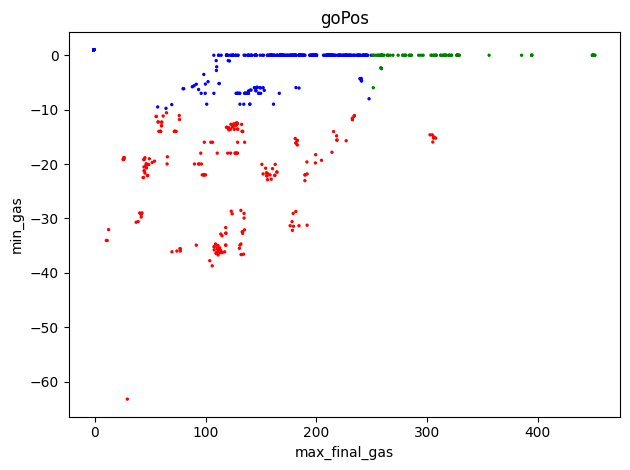

/tmp/ipykernel_161061/3144975635.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


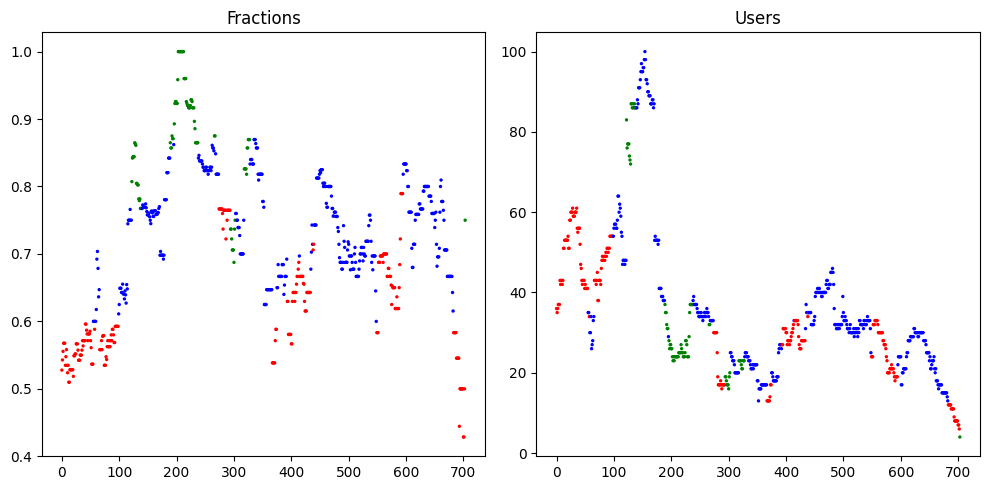

In [45]:
# analyse correlation between min_gas and max_final_gas

# Strategy goPos
min_gas = [r[1] for r in result_dict_sequence["mc_results"]]
max_final_gas = [r[2] for r in result_dict_sequence["mc_results"]]

min_gas_indices = [i for i in range(len(min_gas)) if min_gas[i]<=-10]
print("range min gas", len(min_gas_indices), list(detect_range(min_gas_indices)))

max_final_gas_indices = [i for i in range(len(max_final_gas)) if max_final_gas[i]>=250]
print("range max final", len(min_gas_indices), list(detect_range(max_final_gas_indices)))

colors = ["r" if i in min_gas_indices else "g" if i in max_final_gas_indices else "b" for i in range(len(min_gas))]

plt.scatter(max_final_gas, min_gas, s = 2,  c = colors)
plt.xlabel("max_final_gas")
plt.ylabel("min_gas")
plt.title("goPos")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(range(len(result_dict_sequence["fractions"])), result_dict_sequence["fractions"], s = 2, c = colors)
axs[0].set_title("Fractions")
axs[1].scatter(range(len(result_dict_sequence["sliced_logs"])), [len(l) for l in result_dict_sequence["sliced_logs"]], s = 2, c = colors)
axs[1].set_title("Users")
fig.show()

range min gas 138 [(0, 55), 57, (66, 99), (367, 375), (395, 402), (438, 444), (486, 491), (549, 552), (683, 703)]
range max final 138 [(127, 130), (197, 231), 280, (282, 286), (287, 303), (318, 322), (323, 328), (591, 596), 703]


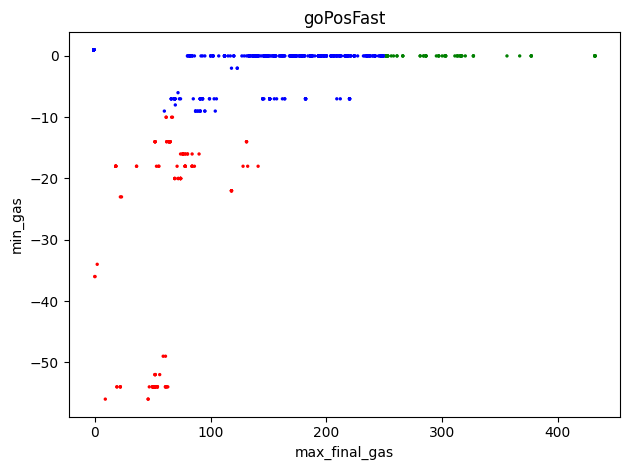

/tmp/ipykernel_161061/746569284.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


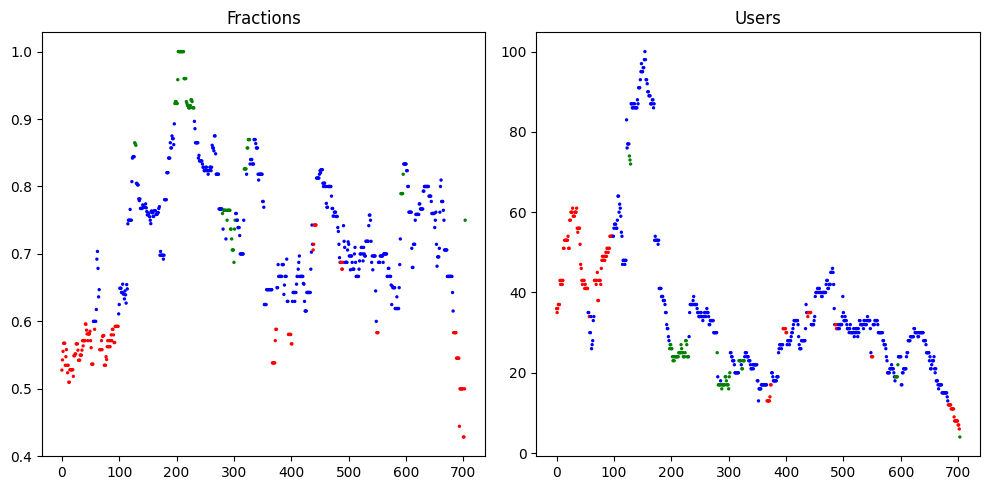

In [46]:
# Strategy goPosFast
min_gas = [r[4] for r in result_dict_sequence["mc_results"]]
max_final_gas = [r[5] for r in result_dict_sequence["mc_results"]]

min_gas_indices = [i for i in range(len(min_gas)) if min_gas[i]<=-10]
print("range min gas", len(min_gas_indices), list(detect_range(min_gas_indices)))

max_final_gas_indices = [i for i in range(len(max_final_gas)) if max_final_gas[i]>=250]
print("range max final", len(min_gas_indices), list(detect_range(max_final_gas_indices)))

colors = ["r" if i in min_gas_indices else "g" if i in max_final_gas_indices else "b" for i in range(len(min_gas))]

plt.scatter(max_final_gas, min_gas, s = 2,  c = colors)
plt.xlabel("max_final_gas")
plt.ylabel("min_gas")
plt.title("goPosFast")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(range(len(result_dict_sequence["fractions"])), result_dict_sequence["fractions"], s = 2, c = colors)
axs[0].set_title("Fractions")
axs[1].scatter(range(len(result_dict_sequence["sliced_logs"])), [len(l) for l in result_dict_sequence["sliced_logs"]], s = 2, c = colors)
axs[1].set_title("Users")
fig.show()

Not computed are sub-logs [(140, 189)]


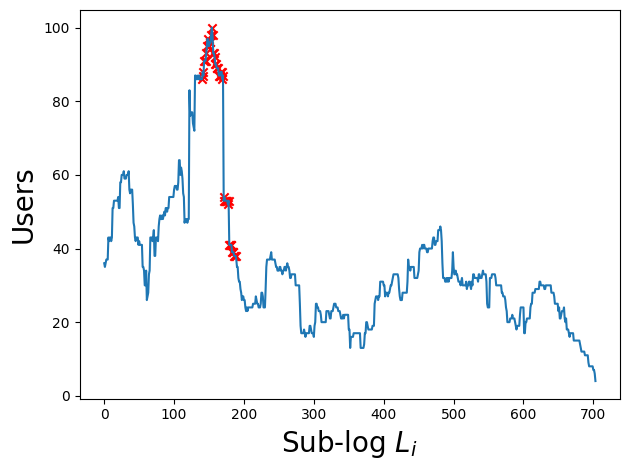

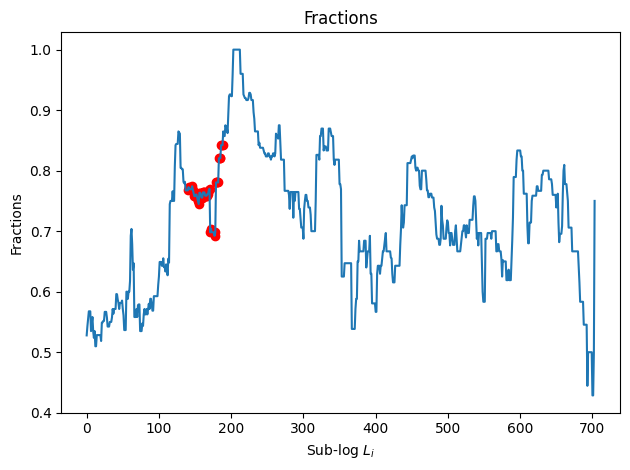

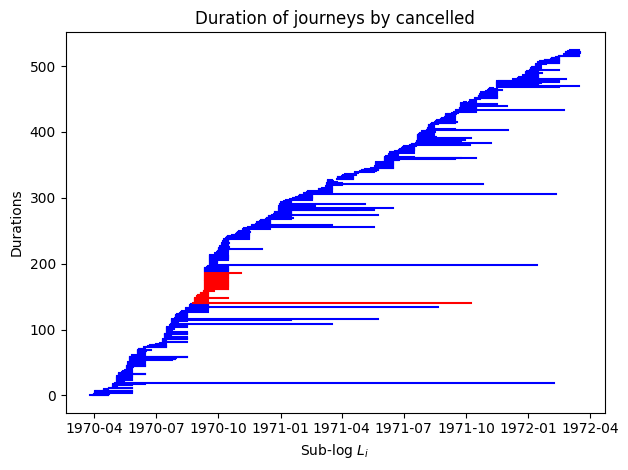

Task event: 1 is followed by vpcAssignInstance [(140, 189), (499, 548)]


In [47]:
# analyse models without MC
not_computed_indices = [i for i in range(len(result_dict_sequence['mc_results'])) if result_dict_sequence['mc_results'][i] == [-1,1,-1,-1,1,-1]]

uncomputed_ranges = list(detect_range(not_computed_indices))
print("Not computed are sub-logs", uncomputed_ranges)

plt.plot(range(len(result_dict_sequence['sliced_logs'])), [len(l) for l in result_dict_sequence["sliced_logs"]])
plt.scatter(not_computed_indices, [[len(l) for l in result_dict_sequence["sliced_logs"]][i] for i in not_computed_indices], c = "r", marker = "x")
plt.xlabel(r'Sub-log $L_i$', size = 20)
plt.ylabel("Users", size = 20)
if SAVE_ELEMENTS:    
    plt.savefig("no_mc.png")
plt.show()

plt.plot(range(len(result_dict_sequence['fractions'])), result_dict_sequence["fractions"])
plt.scatter(not_computed_indices, [result_dict_sequence["fractions"][i] for i in not_computed_indices], c = "r")
plt.title("Fractions")
plt.xlabel(r'Sub-log $L_i$')
plt.ylabel("Fractions")
if SAVE_ELEMENTS:
    plt.savefig("no_mc_fractions.png")
plt.show()

count = 0
for i in range(len(sorted_times)):
    t = sorted_times[i]
    plt.plot([t[1][0],t[1][1]], [count, count], c="red" if i in not_computed_indices else "b")
    count += 1
plt.title("Duration of journeys by cancelled")
plt.xlabel(r'Sub-log $L_i$')
plt.ylabel("Durations")
plt.show()

# Search for logs with trace where "Task event: 1" is followed by "vpcAssignInstance" (error reason)
is_contained = []
for index in range(len(result_dict_sequence["sliced_logs"])):
    l = result_dict_sequence["sliced_logs"][index]
    contained = "False"
    for trace in l:
        for pos in range(len(trace)-1):
            if trace[pos] == "Task event: 1" and trace[pos+1] == "vpcAssignInstance":
                contained = "True"
    is_contained.append(contained)

print("Task event: 1 is followed by vpcAssignInstance", list(detect_range([i for i in range(len(is_contained)) if is_contained[i] == "True"])))

## Analyse negative edges
We investiagte the phases in which gas minima occur by extending the model.

In [48]:
def negative_edge_occurences(logs):
    phases = []
    
    for l in logs:
        if len(l) == 0:
            phases.append("none")
            continue

        # build unrolled process model
        help_g, edge_mapping = transition_system(l, 2, sequence)
        extend_graph_with_actors(help_g,actors, transition_system=True)
        help_edge_cost = compute_edge_cost(help_g, l, edge_mapping)
        help_g = annotate_graph(help_g, help_edge_cost)

        target = [s for s in help_g.nodes if "finPos" in s or "finNeg" in s]
        help_g_unroll = unroll(help_g, "start", target, 1)

        to_uppaal_transition(help_g_unroll, "unrolled_graph_transition.xml", layout = "dot")

        # find min
        out = subprocess.Popen([VERIFYTA_PATH, "unrolled_graph_transition.xml", "min_gas_query.q", "-s"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        results, err = out.communicate()
        results = results.decode("utf-8")
        err = err.decode("utf-8") 
        if err != "":
            phases.append("none")
        else:
            results = results.split("\n")
            results = [i for i in results if "mean=" in i]
            assert(len(results)== 1)
            min_gas = int(float(results[0].split("mean=")[1].split(" ")[0]))

            # start with mean values and go down until can only be achieved in one phase
            results = [True, True, True, True, True]
            while sum(results) > 3: # first two queries have to be true and then one for the phases
                with open("auto_sim.q", 'w+') as outfile:
                    outfile.write("A[] phase0 + phase1 + phase2 == 1 \n") #check that file is correct
                    outfile.write("strategy goPos = control: A<> reached_positive\n")
                    outfile.write("control: A<> gas <= " + str(min_gas) + " && phase0 under goPos \n")
                    outfile.write("control: A<> gas <= " + str(min_gas) + " && phase1 under goPos \n")
                    outfile.write("control: A<> gas <= " + str(min_gas) + " && phase2 under goPos \n")
                out = subprocess.Popen([VERIFYTA_PATH, "-s", "unrolled_graph_transition.xml", "auto_sim.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
                out.wait()
                results, err = out.communicate()
                results = results.decode("utf-8") 
                err = err.decode("utf-8") 
                if err != "":
                    print(err)
                    phases.append("none")
                else:
                    results = results.split("\n")
                    results = [i for i in results if "-- Formula is" in i]
                    results = [False if "NOT" in i else True for i in results]
                    assert(results[0])
                min_gas -= 1
            assert(sum(results)<=3)
            assert(results[0])
            if sum(results) == 3:
                if results[2]:
                    phases.append("start")
                elif results[3]:
                    phases.append("work")
                else:
                    phases.append("submit")
            else:
                phases.append("not found")
    return phases

In [ ]:
phases = negative_edge_occurences(sliced_logs)

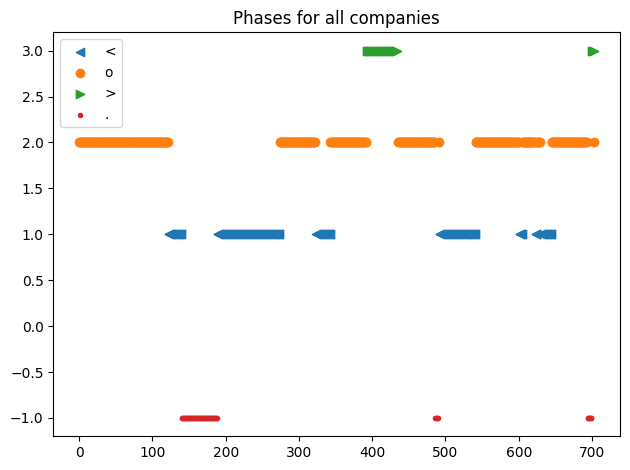

In [50]:
phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases]

x = np.array(range(len(phases)))

for m,h in zip(["<","o",">", "."], [1,2,3,-1]):
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, [h for i in range(len(x_index))], marker = m, label=m)
plt.legend()
plt.title("Phases for all companies")
plt.show()

# Analyse by company
We analyse developments of the largest companies and investigate how Greps can improve individual interactions.

In [51]:
# most prominent companies and their users
reduced_sorted_times = [t for t in sorted_times if (t[1][1]- t[1][0]).days < MAX_DURATION_JOURNEY]
company_counts = {}
for t in reduced_sorted_times:
    company_index = company_iterator[companies[t[0]]]
    if company_index not in company_counts:
        company_counts[company_index] = 1
    else:
        company_counts[company_index] += 1
for c in company_counts:
    if company_counts[c] >= 10:
        print(c, company_counts[c], company_counts[c]/sum([company_counts[h] for h in company_counts]))

print("users total", len(reduced_sorted_times))

8 260 0.5029013539651838
6 96 0.18568665377176016
4 46 0.08897485493230174
12 15 0.029013539651837523
17 14 0.027079303675048357
7 17 0.03288201160541586
10 34 0.06576402321083172
users total 517


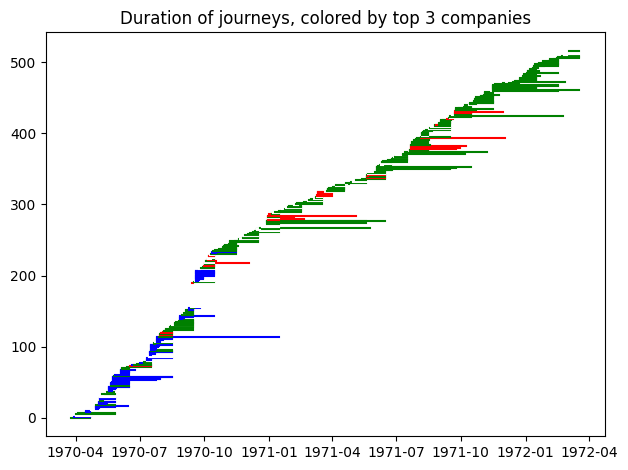

In [52]:
# top 3 companies
count = 0

for t in reduced_sorted_times:
    # 3 companies represent 80% of users
    company_it = company_iterator[companies[t[0]]]
    if company_it == 4:
        color = "red"
    elif company_it == 6:
        color = "blue"
    elif company_it == 8:
        color = "green"
    else:
        color = "white"
    plt.plot([t[1][0],t[1][1]], [count, count], c=color)
    count += 1
plt.title("Duration of journeys, colored by top 3 companies")
plt.show()


In [53]:
# construct the companiy specific sliding-window logs
def filter_by_company(sliced_logs, sliced_companies, company):
    filtered_logs = []
    for l, companies in zip(sliced_logs, sliced_companies):
        current_log = [l[i] for i in range(len(l)) if companies[i] == company]
        filtered_logs.append(current_log)
    return filtered_logs

sliced_log_8 = filter_by_company(sliced_logs, sliced_companies, 8)
sliced_log_6 = filter_by_company(sliced_logs, sliced_companies, 6)
sliced_log_4 = filter_by_company(sliced_logs, sliced_companies, 4)

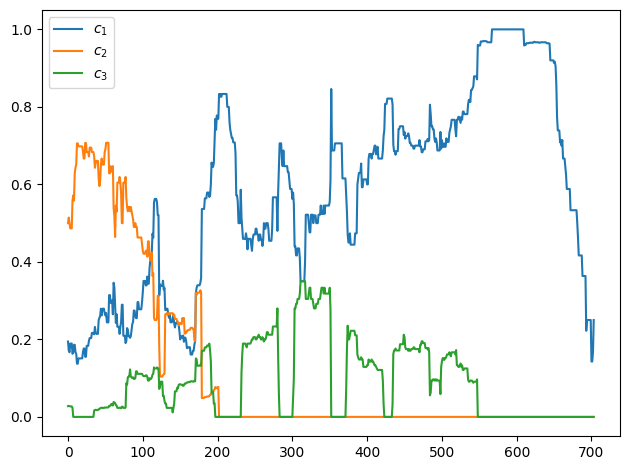

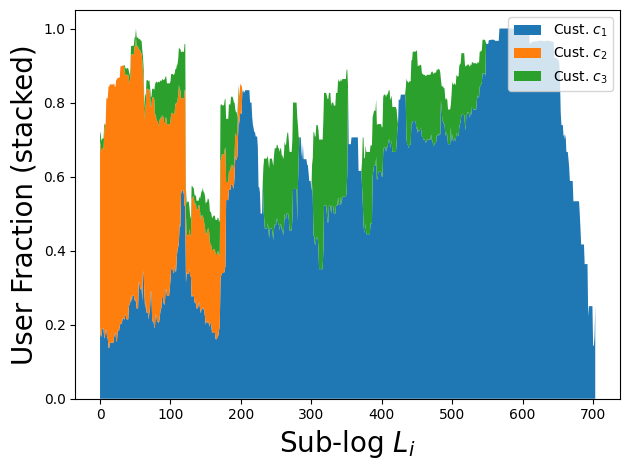

In [54]:
# plot general developments for top 3 companies
plt.plot(range(len(sliced_log_8)),[len(sliced_log_8[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_1$')
plt.plot(range(len(sliced_log_6)), [len(sliced_log_6[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_2$')
plt.plot(range(len(sliced_log_4)), [len(sliced_log_4[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_3$')
plt.legend()
plt.show()

d4 = [len(sliced_log_4[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]
d6 = [len(sliced_log_6[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]
d8 = [len(sliced_log_8[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]

y = np.vstack([d8, d6, d4])
labels = [r'Cust. $c_1$', r'Cust. $c_2$', r'Cust. $c_3$']
plt.stackplot(range(len(sliced_logs)), y, labels = labels)
plt.xlabel(r'Sub-log $L_i$', size = 20)
plt.ylabel("User Fraction (stacked)", size = 20)
plt.legend()
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/company_ratios.png")
plt.show()

## Time series analysis for top 3 companies
We investigate changes over time for the three companies individually. 
It is from interest if global trends or new local trends can be detected

In [ ]:
result_dict_help_4 = time_analysis(sliced_log_4, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_4)

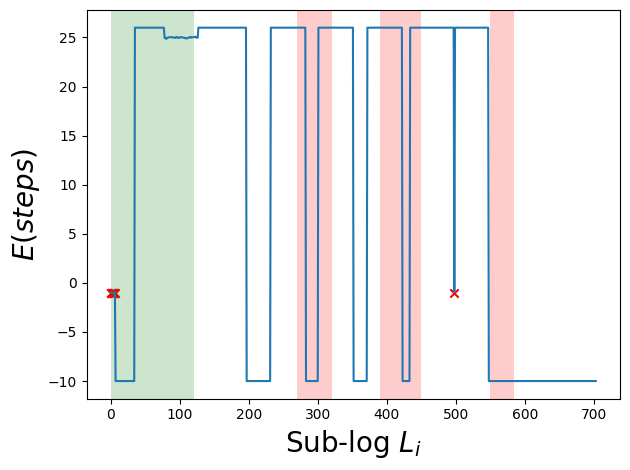

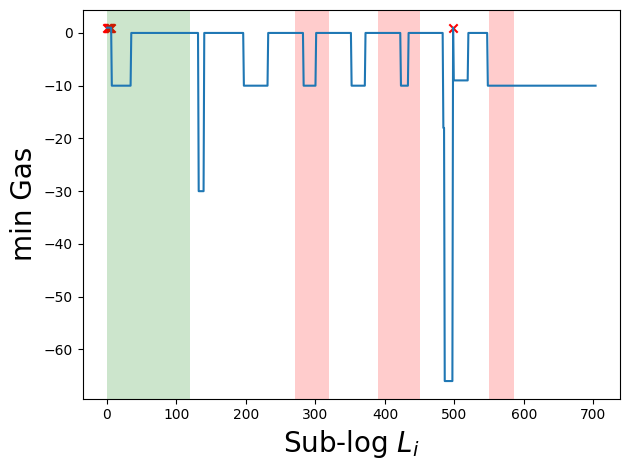

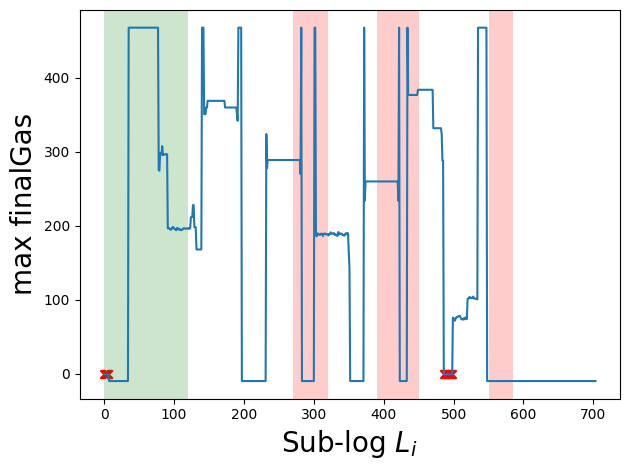

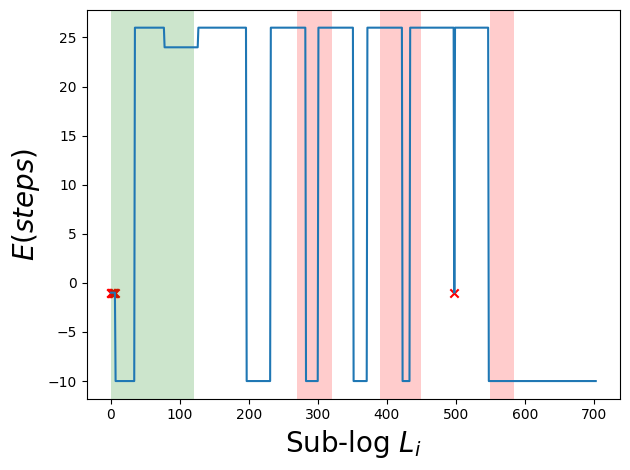

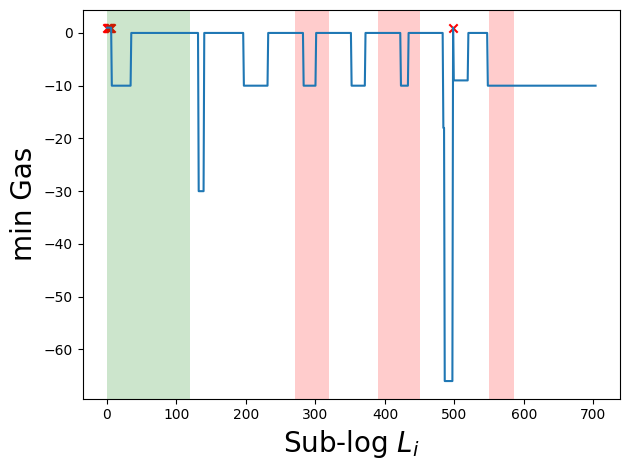

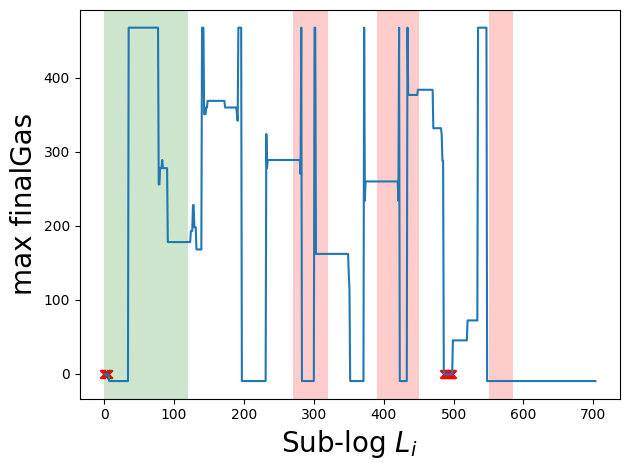

In [56]:
plot_mc_results(result_dict_help_4["mc_results"], result_dict_help_4["colors"])

In [ ]:
result_dict_help_6 = time_analysis(sliced_log_6, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_6)

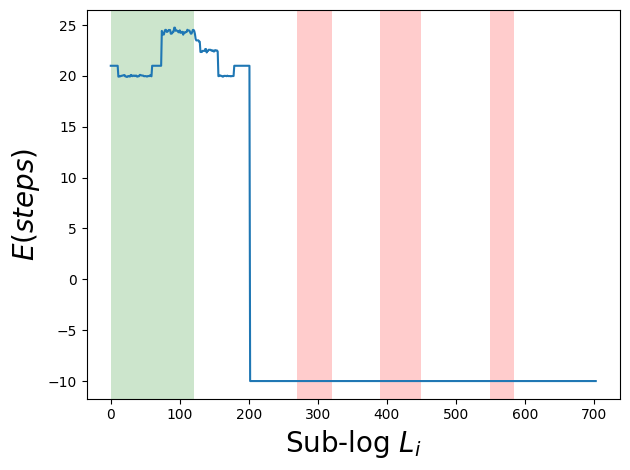

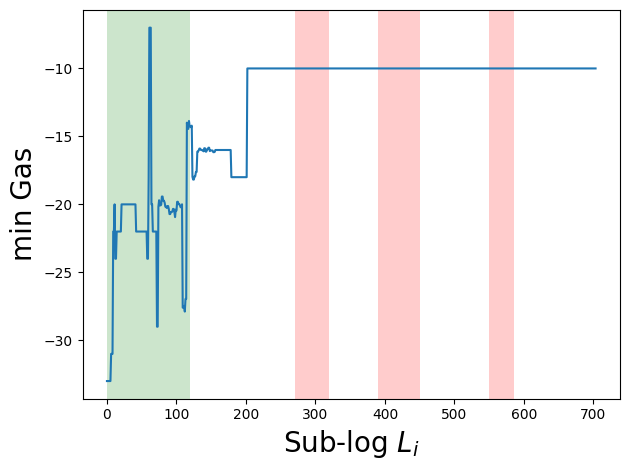

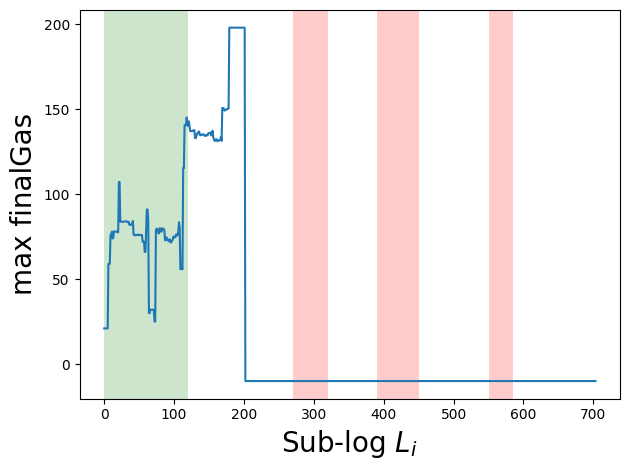

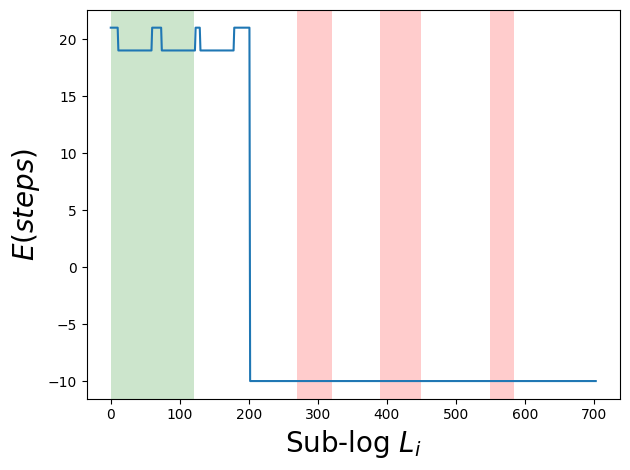

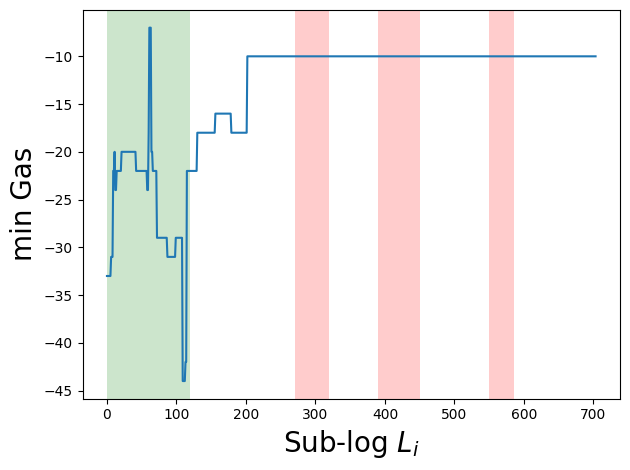

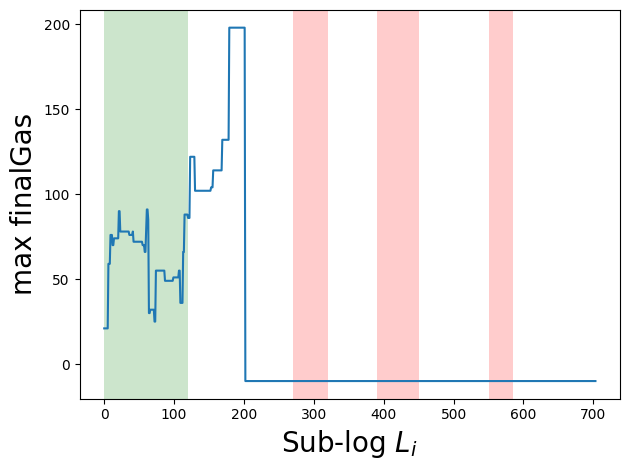

In [58]:
plot_mc_results(result_dict_help_6["mc_results"], result_dict_help_6["colors"])

In [ ]:
# investigate phases for company 6
phases_6 = negative_edge_occurences(sliced_log_6)

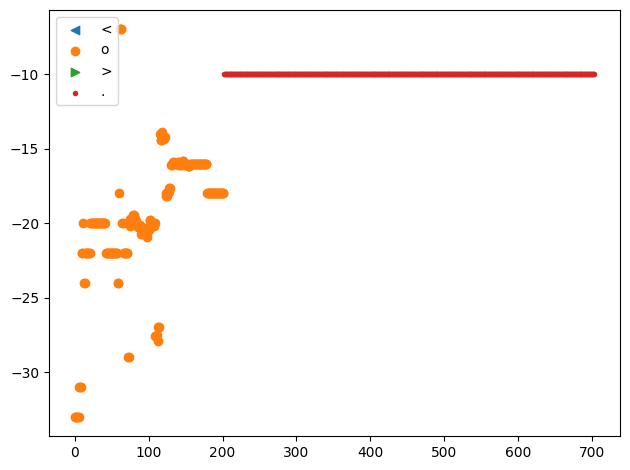

In [60]:
# plot phases and minimum gas
phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases_6]
x = np.array(range(len(phases_6)))
for m in ["<","o",">", "."]:
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, np.array([r[1] for r in result_dict_help_6["mc_results"]])[x_index], marker = m, label = m)

plt.legend()
if SAVE_ELEMENTS:
    plt.savefig("steps_6.png")
plt.show()

In [ ]:
result_dict_help_8 = time_analysis(sliced_log_8, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_8)

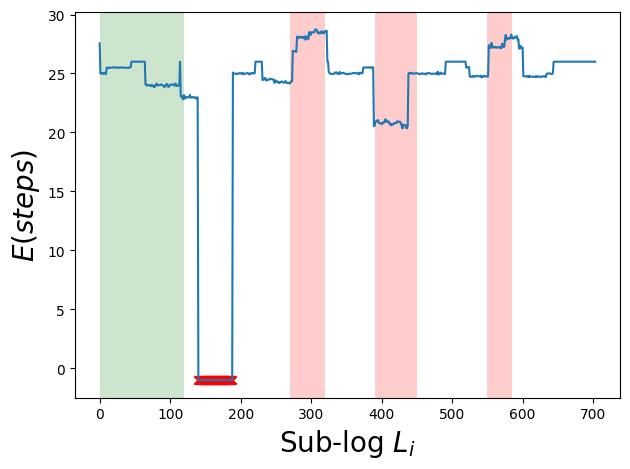

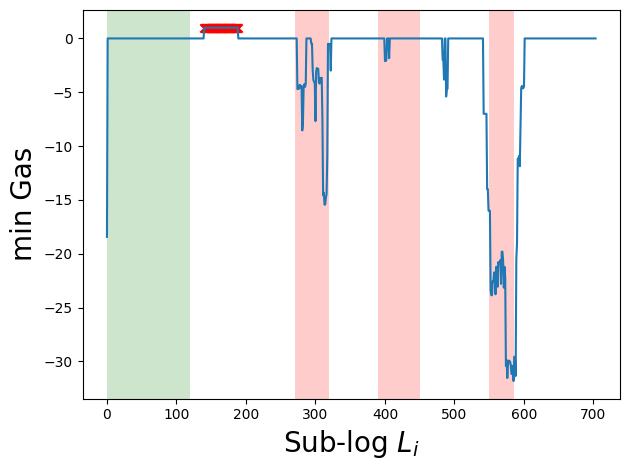

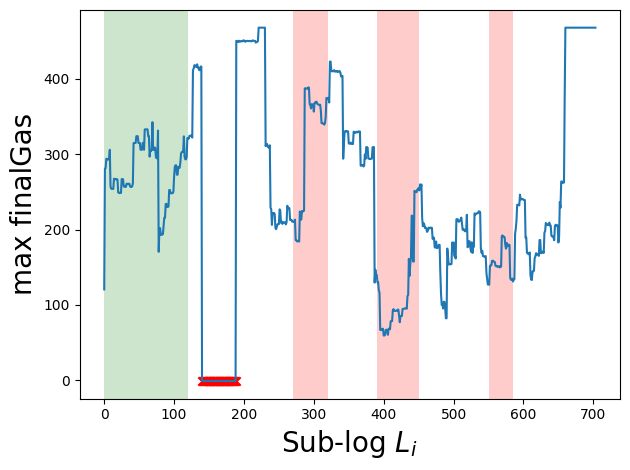

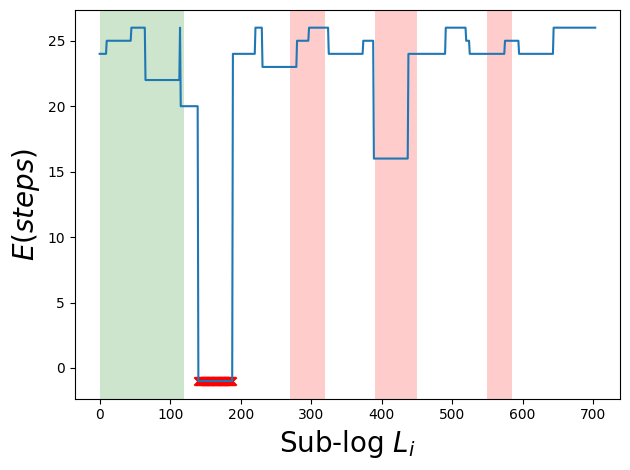

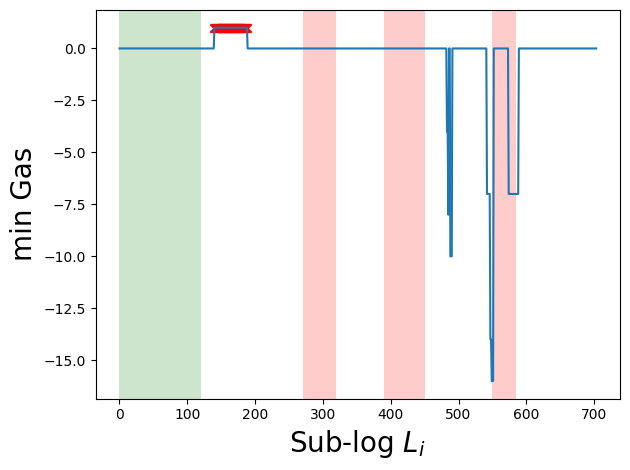

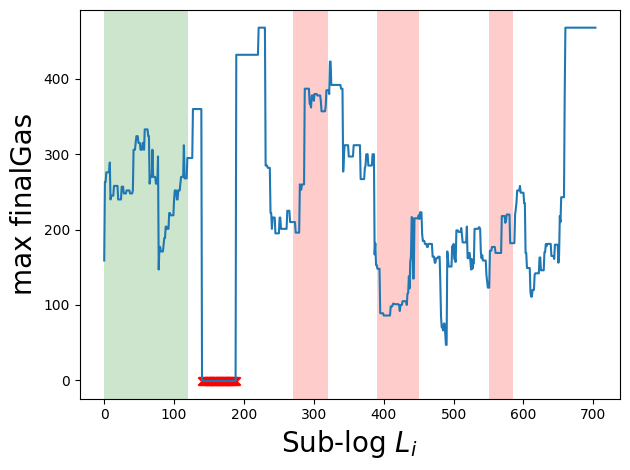

In [62]:
plot_mc_results(result_dict_help_8["mc_results"], result_dict_help_8["colors"])

In [ ]:
phases_8 = negative_edge_occurences(sliced_log_8)

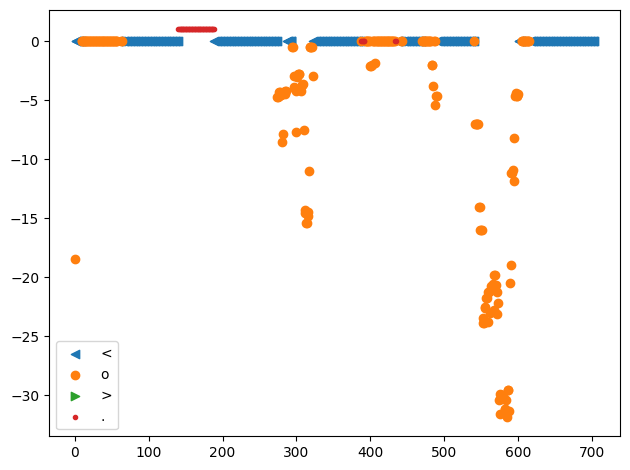

In [64]:
phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases_8]
x = np.array(range(len(phases_8)))
for m in ["<","o",">", "."]:
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, np.array([r[1] for r in result_dict_help_8["mc_results"]])[x_index], marker = m, label = m)
plt.legend()
if SAVE_ELEMENTS:
    plt.savefig("steps_8.png")
plt.show()

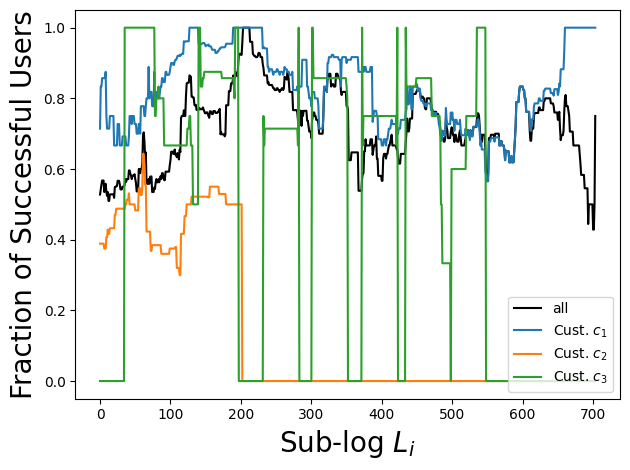

/tmp/ipykernel_161061/3243434090.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_161061/3243434090.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


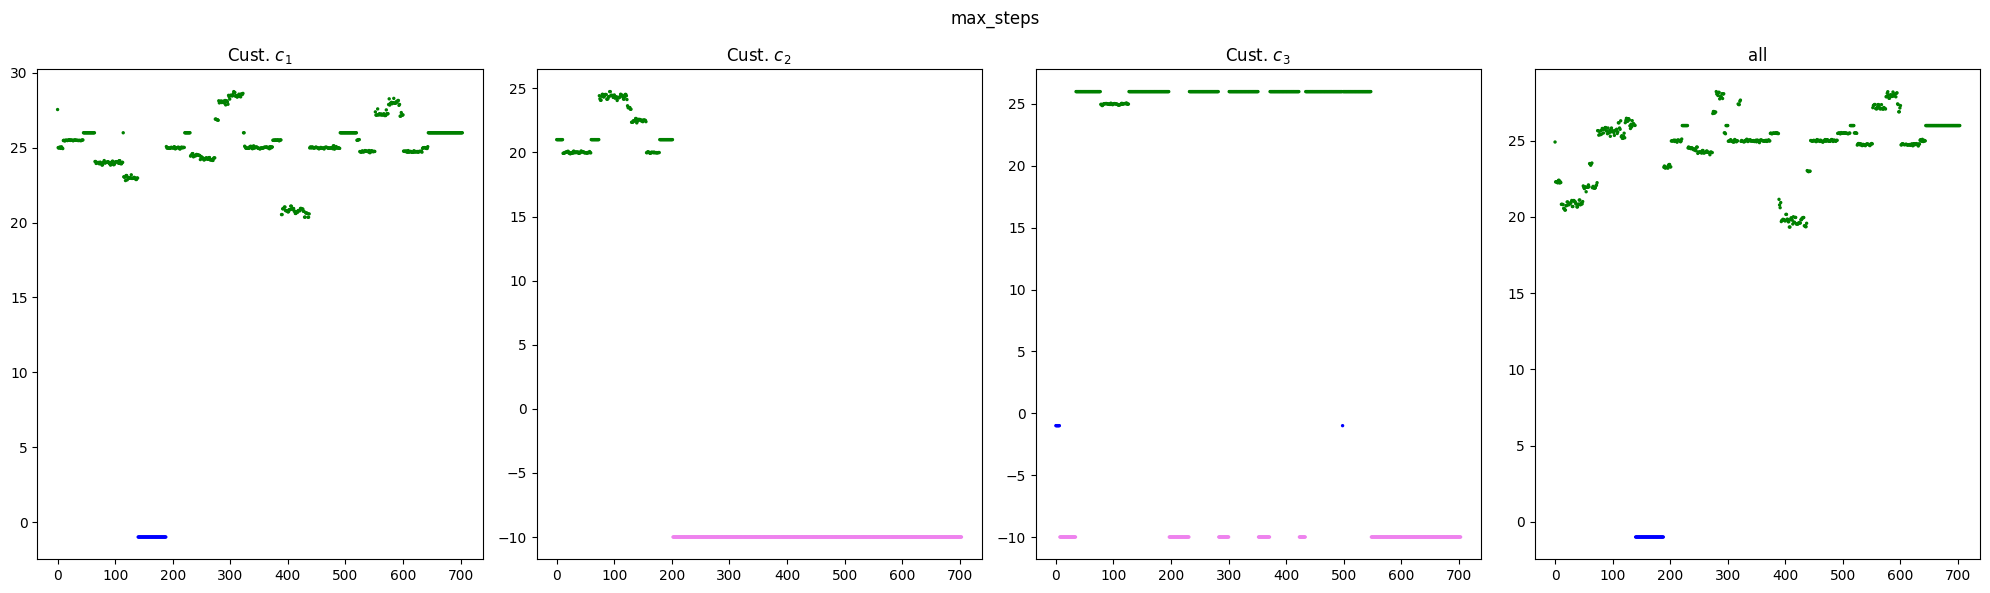

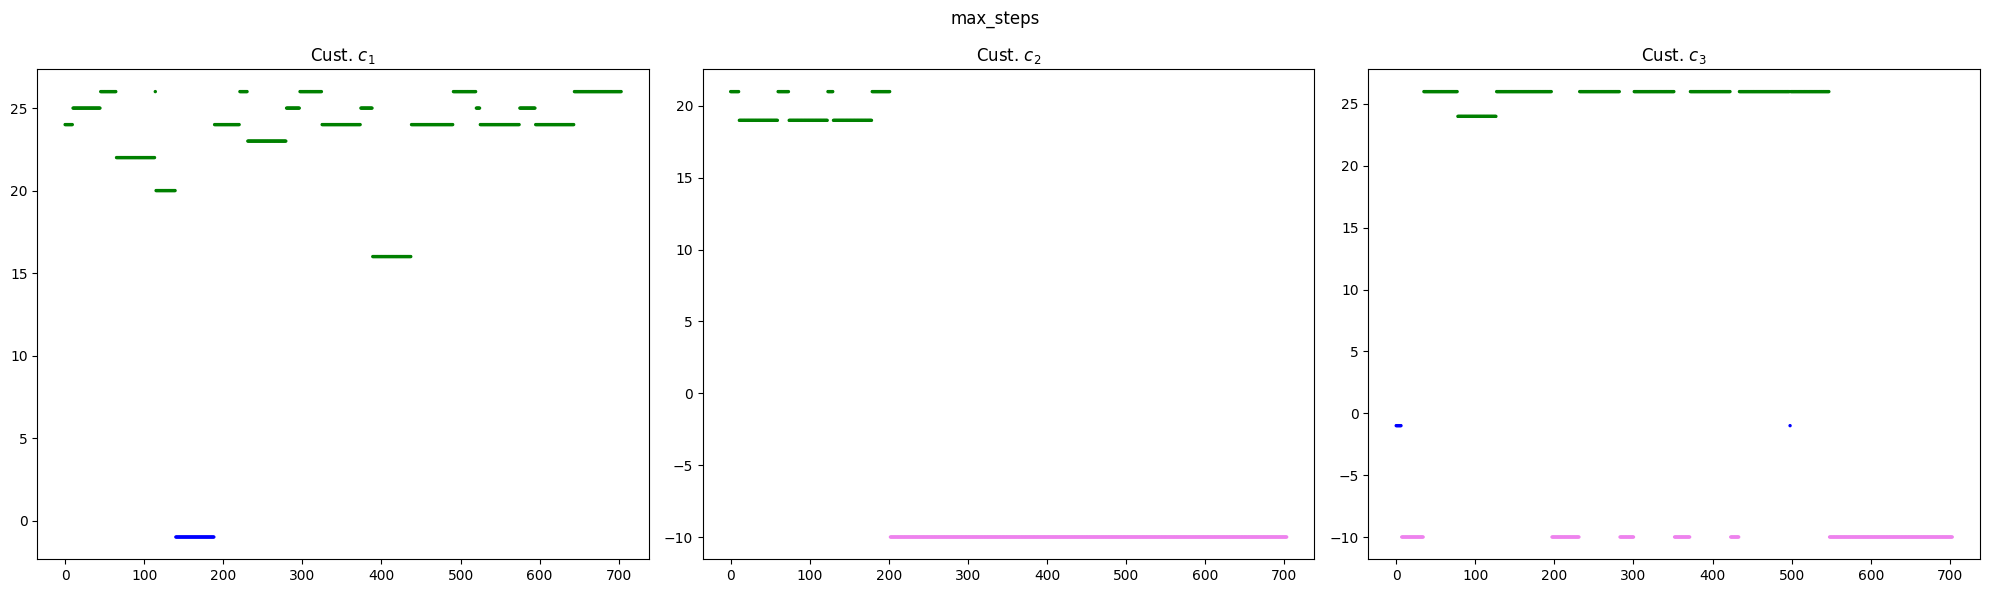

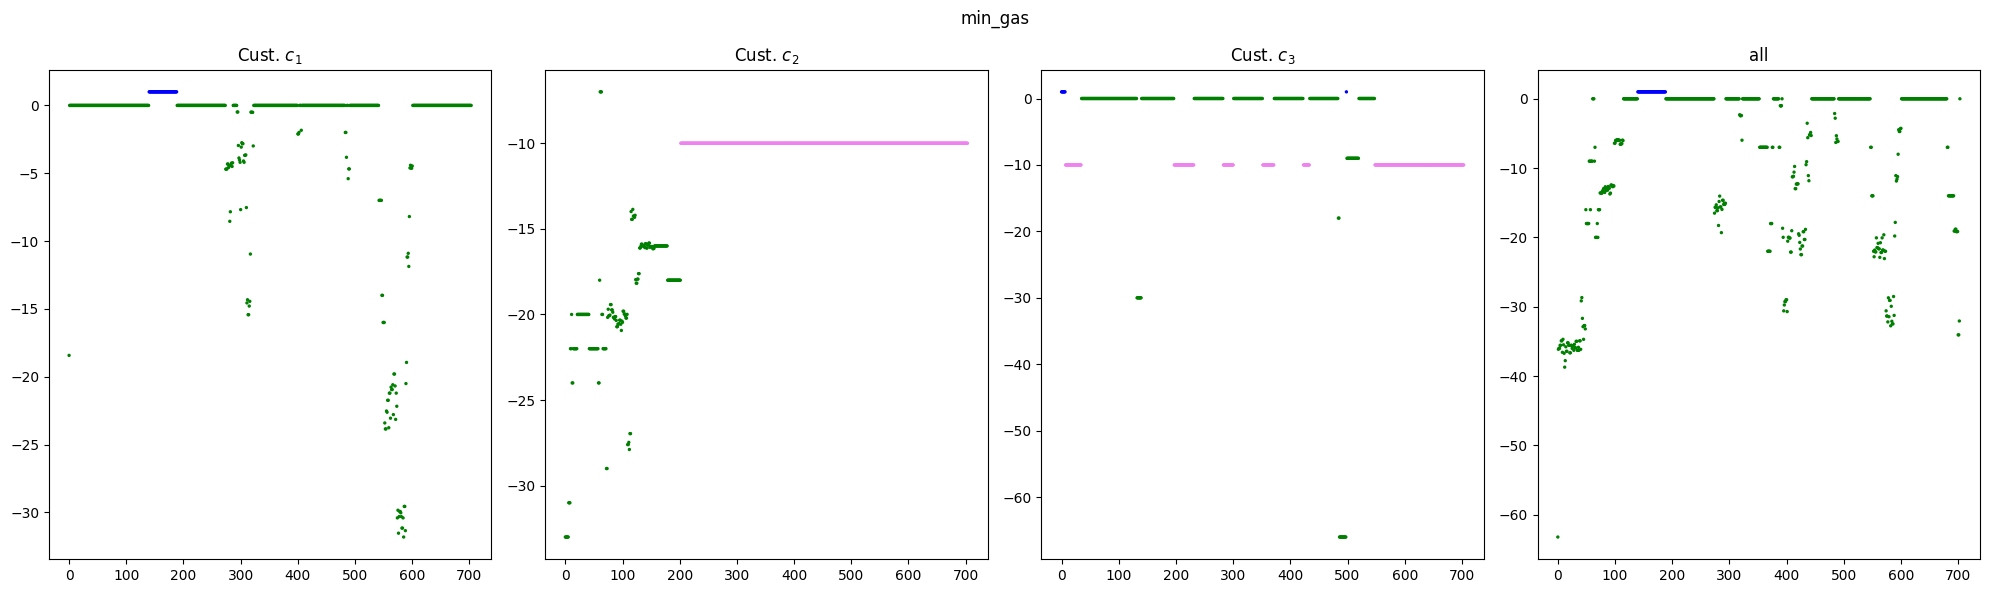

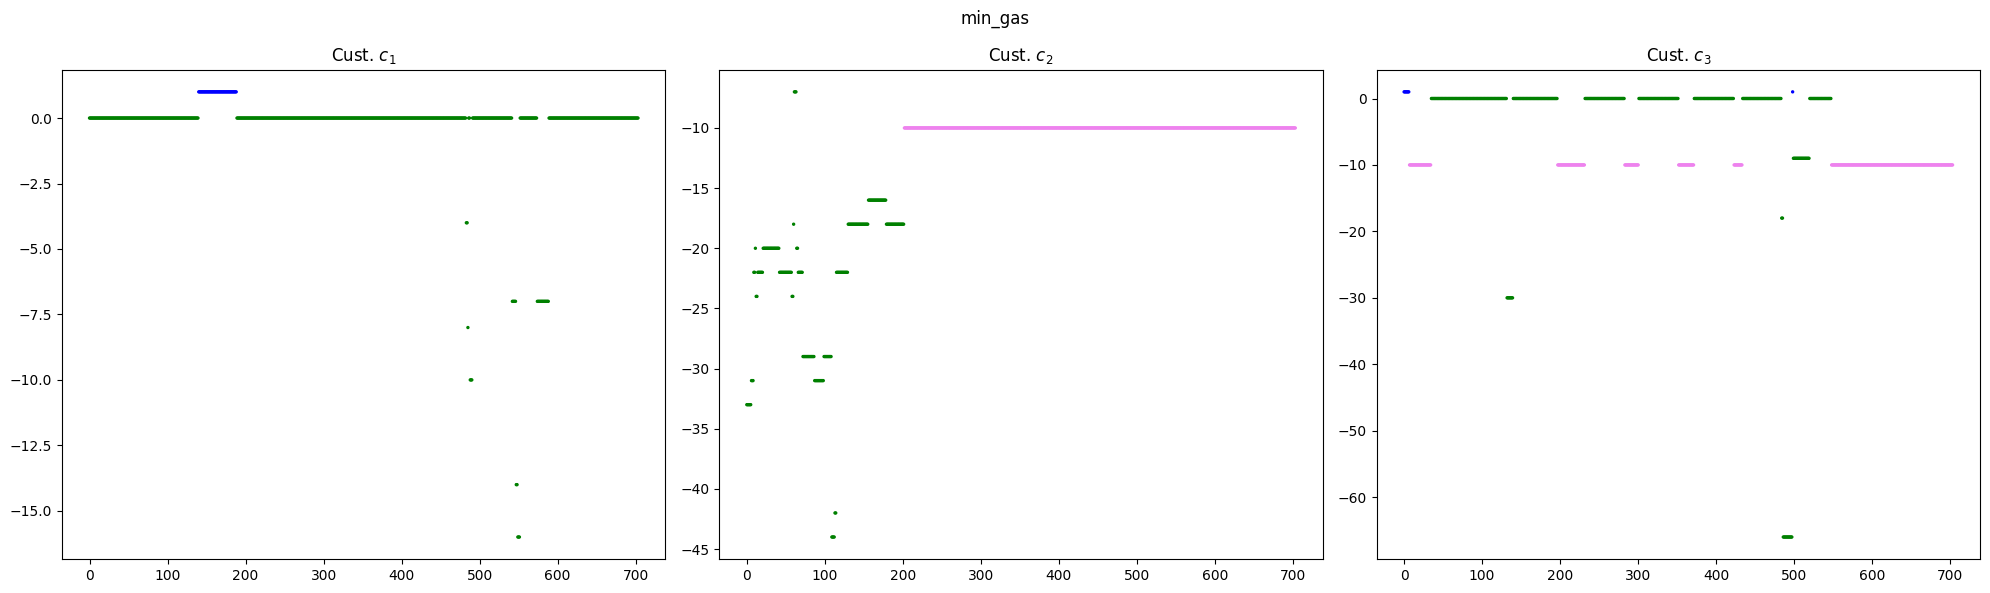

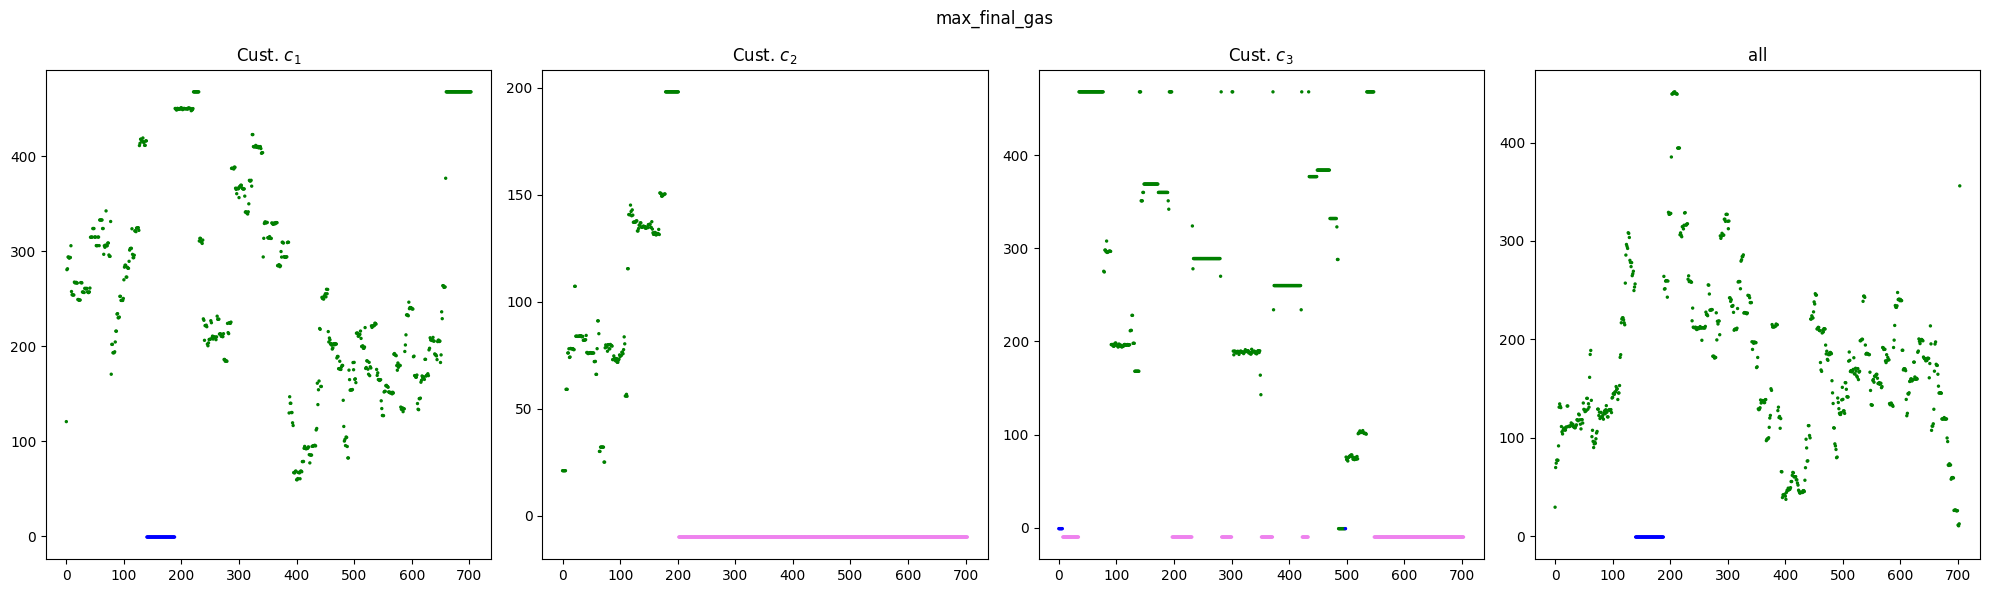

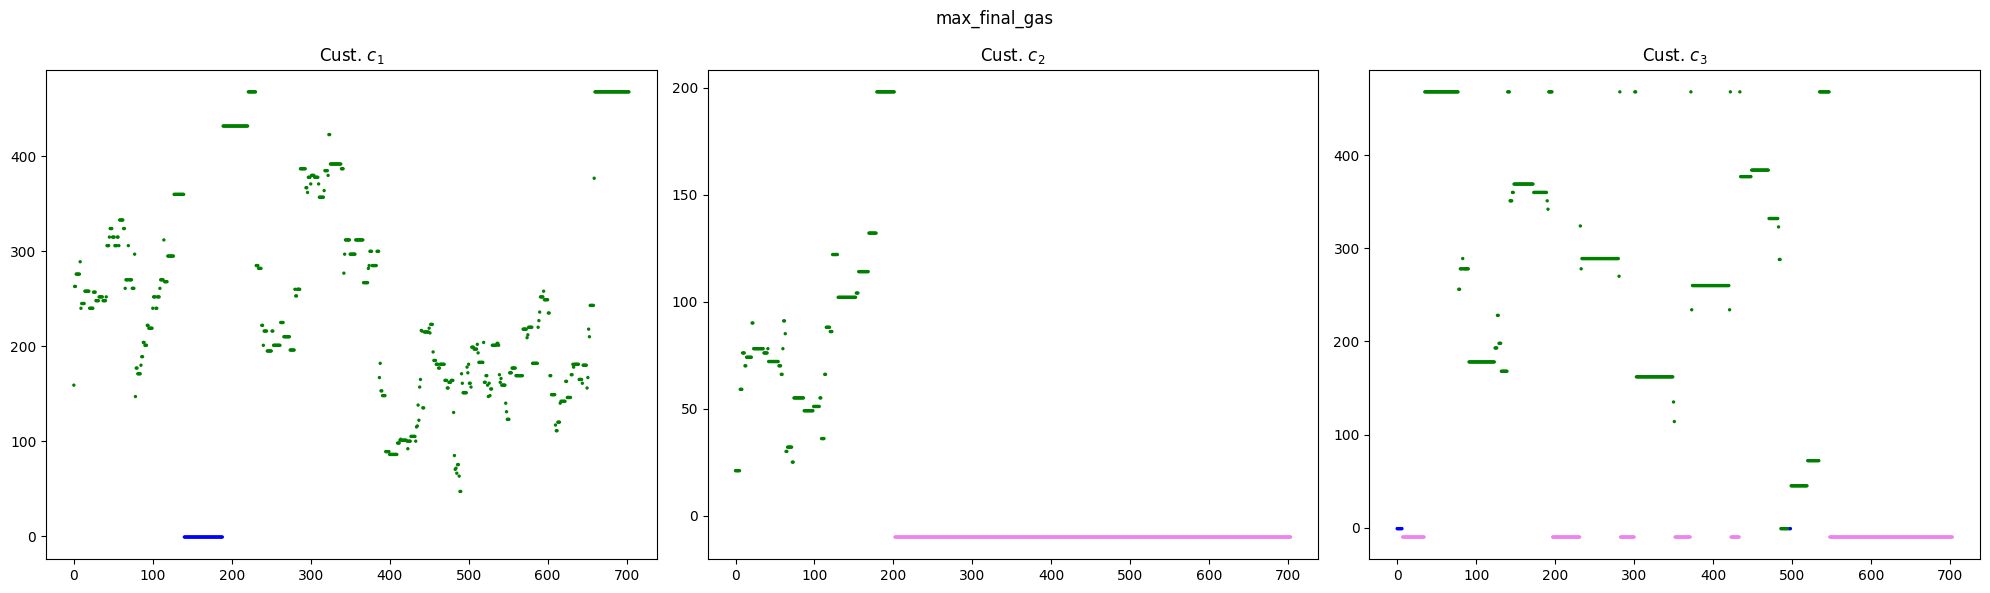

In [65]:
# todo clean from here
result_dicts = [result_dict_help_8,result_dict_help_6,result_dict_help_4]
sub_titles = [r'Cust. $c_1$', r'Cust. $c_2$', r'Cust. $c_3$']
colors = ["blue", "orange", "green"]

fractions = []
for l in sliced_logs:
    pos = [t for t in l if "finPos" in t]
    neg = [t for t in l if "finNeg" in t]
    fractions.append(len(pos)/len(l))
    assert(len(pos)+len(neg) == len(l))

plt.plot(range(len(fractions)), fractions, label = "all", c = "black") # global value
for dict, label, color in zip(result_dicts, sub_titles, colors):
    x = dict["fractions"]
    x = [e if e != -1 else 0 for e in x]
    plt.plot(range(len(x)), x, label = label)
    
plt.legend(loc = 'lower right')
plt.xlabel(r'Sub-log $L_i$', size = 20)
plt.ylabel("Fraction of Successful Users", size = 20)
if SAVE_ELEMENTS:
    plt.savefig("company_fractions.png")
plt.show()

lables = ["max_steps", "min_gas", "max_final_gas"]
n = len(result_dicts)

for j in range(3):
    fig, axs = plt.subplots(1,n+1, figsize=(20, 6))
    axs[n].scatter(range(len(result_dict_sequence["mc_results"])), [r[j] for r in result_dict_sequence["mc_results"]], s = 2, c = result_dict_sequence["colors"])
    axs[n].set_title("all")
    for i in range(n):
        axs[i].scatter(range(len(result_dicts[i]["mc_results"])), [r[j] for r in result_dicts[i]["mc_results"]], s = 2, c = result_dicts[i]["colors"])
        axs[i].set_title(sub_titles[i])
    fig.suptitle(lables[j%3])
    if SAVE_ELEMENTS:
        plt.savefig("company"+lables[j%3]+".png")
    fig.show()

    fig, axs = plt.subplots(1,n, figsize=(20, 6))
    for i in range(n):
        axs[i].scatter(range(len(result_dicts[i]["mc_results"])), [r[j+3] for r in result_dicts[i]["mc_results"]], s = 2, c = result_dicts[i]["colors"])
        axs[i].set_title(sub_titles[i])
    fig.suptitle(lables[j%3])
    fig.show()
